# Cutout with twin color pairs  multi colors

- author Sylvie Dagoret-Campagne
- creation date 2024-06-21
- last update 2024-06-22
- affiliation : IJCLab
- Kernel **w_2024_16**

- 1) Start by two-objects-lists sources in different bands. Thowe object are close enough to expect their visit in same calexp frequently
- 2) **Merge above visits lists**  in same band/same calexp for object 1 and Object 2 : df_g, df_r, df_z, df_y
- 3) Find closest time visit in other bands : dfg_r,

In [1]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor=None, alpha=0.1)
#props = dict(boxstyle='round')


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit

In [3]:
import gc

In [4]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time
import scipy

In [5]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [6]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

#import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle
import lsst.sphgeom

In [7]:

from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure

In [8]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [9]:
transform = AsinhStretch() + PercentileInterval(99.)

In [10]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240513/w_2024_20/PREOPS-5146' # test this one today 2024/06/22

collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
patch_sel = 236
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [11]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [12]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=collections)

## Definition of functions used

In [13]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [14]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [15]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [16]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [17]:
def cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

In [18]:
def create_rgb(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [19]:
def find_neighbourg(ra0,dec0,src):
    """ 
    Calculate the angular separation of a list of sources in src pandas table from a (ra0,dec0) source location
    """
    all_angles = []
    for index, row in src.iterrows():
        spherePointCenter = lsst.geom.SpherePoint(ra0*lsst.geom.degrees, dec0*lsst.geom.degrees)
        spt = lsst.geom.SpherePoint(row["ra"]*lsst.geom.degrees, row["dec"]*lsst.geom.degrees)
        ang = spherePointCenter.separation(spt)
        ang_arcsec = ang.asArcseconds()
        all_angles.append(ang_arcsec)
    return all_angles

In [20]:
def PlotAndFitHisto(data,std_clip,ax,nbins=50,xlabel=r'$(G-R)_1 - (G-R)_2$ :',title="Differential color with 2 stars",xmin=-100.,xmax=100.):
    #data = df_col_gr["ratio3"].values

    hist, bin_edges = np.histogram(data,bins=nbins,range=(xmin,xmax),density=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [1., 0., 1.]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    # Get the fitted curve
    hist_fit = gauss(bin_centres, *coeff)

    textstr = '\n'.join((
    xlabel,
    r'$\sigma_{clipped} = %.01f$ mmag' %(std_clip,),
    r'$\sigma_{fit} = %.01f$ mmag' %(coeff[2], )))

    ax.step(bin_centres, hist,'k' ,label='data')
    ax.plot(bin_centres, hist_fit,'r-', label='fit')
    ax.set_xlabel(xlabel)
    ax.legend()
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="blue", weight='bold',bbox=props)
    ax.set_title(title)
    ax.set_xlim(xmin,xmax)
    # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
    #print('Fitted mean = ', coeff[1])
    #print('Fitted standard deviation = ', coeff[2])

In [21]:
def closestvisit(df1,df2):
    """
    This function associate pairs of closest observation

    input : the 2 dataframes (first to one for which one want to find the closest obs in dtaframe 2)
    output : the dataframe of similar format as the first one having columns on nightobs , visit time, dt from second dataframe)
    """
    d1 =df1.copy(deep=True)
    d2 =df2.copy(deep=True)
    all_samples = []
    df = pd.DataFrame(index=d1.index,columns=["nightObs2","visit2","time2","deltat"])
    for key in d1.index:

        nightObs = key[0]
        time1 = d1.loc[key]["time"]
        d2["dt"] = np.abs(d2["time"]-time1)
        d2["Dt"] = d2["time"]-time1
        cut_sel = (d2["dt"] == d2["dt"].min()) #& (d2["nightObs"] == nightObs)
        sample = d2[cut_sel]
        #df.iloc[key] = [sample.index[0][0],sample.index[0][1],sample["time"].values[0],sample['dt'].values[0]]
        df.loc[key]["nightObs2"] = sample.index[0][0]
        df.loc[key]["visit2"] = sample.index[0][1]
        df.loc[key]["time2"] = sample["time"].values[0]
        df.loc[key]["deltat"] = pd.to_timedelta(sample["Dt"].values[0], unit="s").total_seconds()
        all_samples.append(sample)

    # select observations during the same night
    df_back = df.copy(deep=True)
    flag_sel = []
    for key in df_back.index:
        nightObs = key[0]
        nightObs2 = df_back.loc[key]["nightObs2"]
        flag_sel.append(nightObs == nightObs2)
    df = df[flag_sel]
    return df

In [22]:
def getcutoutandimage(visitId,df_selectedvisits):
    """
    visitId : the calexp where are the two stars
    df_selectedvisits : the list of all sources and visit of the main targeted star
    """

    row_source = df_selectedvisits[df_selectedvisits.visit == visitId].iloc[0]  
    band = row_source['band']

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)   
    src_cat = butler.get('sourceTable',**dataId, collections=collections)

    #select on star
    #src_cat = src_cat[(src_cat["extendedness"]==0) & (src_cat["parentSourceId"] == 0) ]
    #src_cat = src_cat[src_cat["extendedness"]==0 ]

    x1 = row_source['x_x']
    y1 = row_source['y_x']
    ra1= row_source['ra_x']
    dec1= row_source['dec_x']
    psfMag1  = row_source['psfMag_x']  
    psfSigma1 = row_source['psfSigma_x']
    psfMagDiffMmag1 = row_source['psfMagDiffMmag_x'] 
    apFlux_50_0_instFlux1 = row_source['apFlux_50_0_instFlux_x']
    apFlux_50_0_instFluxErr1 = row_source['apFlux_50_0_instFluxErr_x']


    x2 = row_source['x_y']
    y2 = row_source['y_y']
    ra2= row_source['ra_y']
    dec2= row_source['dec_y']
    psfMag2  = row_source['psfMag_y']  
    psfSigma2 = row_source['psfSigma_y']
    psfMagDiffMmag2 = row_source['psfMagDiffMmag_y'] 
    apFlux_50_0_instFlux2 = row_source['apFlux_50_0_instFlux_y']
    apFlux_50_0_instFluxErr2 = row_source['apFlux_50_0_instFluxErr_y']

    
    # searcch the neighbouring stars
    #separation = find_neighbourg(ra_target,dec_target,src_cat)
    #src_cat["sep"] = separation


    spherePointCenter = lsst.geom.SpherePoint(ra1*lsst.geom.degrees, dec1*lsst.geom.degrees)
    spt = lsst.geom.SpherePoint(ra2*lsst.geom.degrees, dec2*lsst.geom.degrees)
    ang = spherePointCenter.separation(spt)
    ang_arcsec = ang.asArcseconds()
    
   
    x0 = (x1+x2)/2.
    y0 = (y1+y2)/2.
    ra0 = (ra1+ra2)/2.
    dec0 = (dec1+dec2)/2.
    

    dx1 = x1-x0
    dy1 = y1-y0
    dx2 = x2-x0
    dy2 = y2-y0
    
    
    boxSize = int(max(np.abs(x1-x2),np.abs(y1-y2)))
    xmin= x0-boxSize
    xmax= x0+boxSize
    ymin= y0-boxSize
    ymax= y0+boxSize
        
    
    minBbox = geom.Point2I(int(x0) - boxSize ,int(y0) - boxSize)
    maxBbox = geom.Point2I(int(x0) + boxSize, int(y0) + boxSize)
    
    srcBbox = geom.Box2I(minBbox, maxBbox)


    row_source['x0'] = x0
    row_source['y0'] = y0
    row_source['xmin'] = xmin
    row_source['ymin'] = ymin
    row_source['xmax'] = xmax
    row_source['ymax'] = ymax
    row_source['ra0'] = ra0
    row_source['dec0'] = dec0

    row_source['x1'] = x1
    row_source['y1'] = y1
    row_source['dx1'] = dx1
    row_source['dy1'] = dy1
    row_source['ra1'] = ra1
    row_source['dec1'] = dec1

    row_source['x2'] = x2
    row_source['y2'] = y2
    row_source['dx2'] = dx2
    row_source['dy2'] = dy2
    row_source['ra2'] = ra2
    row_source['dec2'] = dec2
    
    
    # Make the cutout
    try:
        subimg = afwImage.ExposureF(calexp, srcBbox, afwImage.PARENT, True)
        #subimg2 = calexp.getImage().array[int(ySrc) - boxSize: int(ySrc) + boxSize+1, int(xSrc) - boxSize:int(xSrc) + boxSize+1 ]
        #subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)
        #all_cutout.append(subimgRgb)
        cutout=subimg.image.array
        
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)     
        cutout = None

    df_pair = row_source.to_frame()
    return row_source,cutout



In [23]:
def plotfullcalexp(row_pair,ax=None):
    """
    """
    flag_ax = False
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
    else:
        flag_ax = True

    band = 0
    ra = 0
    dec = 0

    x0 = row_pair["x0"]
    y0 = row_pair["y0"]
    
    visitId = row_pair["visit"]
    band = row_pair["band"]
    psfMag1 = row_pair["psfMag_x"]
    psfSigma1 = row_pair["psfSigma_x"]
    x1 = row_pair["x1"]
    y1 = row_pair["y1"]
    ra1 = row_pair['ra2']
    dec1 = row_pair['dec2']
    ann1 = Annulus((x1,y1),r=5*psfSigma1,width=0.1,color="r")
    ax.add_patch(ann1)

  
    psfMag2 = row_pair["psfMag_y"]
    psfSigma2 = row_pair["psfSigma_y"]
    x2 = row_pair["x2"]
    y2 = row_pair["y2"]
    ra2 = row_pair['ra2']
    dec2 = row_pair['dec2']
    ann2 = Annulus((x2,y2),r=5*psfSigma2,width=0.1,color="orange")
    ax.add_patch(ann2)

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)
    imgarr = calexp.image.array 
    shape =  imgarr.shape
    #extent = [x0-shape[1]/2., x0+shape[1]/2., y0-shape[0]/2., y0+shape[0]/2.]
   
    z = ZScaleInterval()
    z1,z2 = z.get_limits(imgarr)
    im = ax.imshow(imgarr,origin="lower",cmap="grey",vmin=z1, vmax=z2)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="1%")
    # useless with zscale
    plt.colorbar(im, cax=cax)

    
    title = f"calexp {visitId}, objidx:{objectname1},{objectname2} band :{band}"
    ax.set_title(title)
    ax.axvline(x0,color="w",linestyle=":")
    ax.axhline(y0,color="w",linestyle=":")
    

    textstr = '\n'.join((
    r'$exposure = %.0f$' % (visitId, ),
    r'$psfMag1 = %.02f mag$' %(psfMag1, ), 
    r'$psfMag2 = %.02f mag$' %(psfMag2, ),  
    r'$ra_1 = %f deg $' %(ra1,),
    r'$ra_2 = %f deg $' %(ra2,),  
    r'$dec_1 = %f deg $' %(dec1,),
    r'$dec_2 = %f deg $' %(dec2,)))  
  

    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="y", weight='bold',bbox=props) 
    #if flag_deblend_skipped:
    #    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="r", weight='bold',bbox=props) 
    #else:
    #    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="g", weight='bold',bbox=props) 

    if not flag_ax:
        plt.show()   

In [24]:
def plotcutout(row_pair,cutout,ax=None):
    """
    """
    flag_ax = False
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,5))
    else:
        flag_ax = True

    if cutout is None:
        print("No Cutout")
        return

    boxSize= cutout.shape[0]//2
    extent = [ row_pair['xmin'], row_pair['xmax'], row_pair['ymin'], row_pair['ymax']]
    
    z = ZScaleInterval()
    z1,z2 = z.get_limits(cutout)
    im = ax.imshow(cutout,origin='lower',cmap="grey",vmin=z1, vmax=z2,extent = extent)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad="1%")
    # useless with zscale
    #plt.colorbar(im, cax=cax)

  

    band = 0
    ra = 0
    dec = 0
    
  
    visitId = row_pair["visit"]
    band = row_pair["band"]
    psfMag1 = row_pair["psfMag_x"]
    psfSigma1 = row_pair["psfSigma_x"]
    x1 = row_pair["x1"]
    y1 = row_pair["y1"]
    ra1 = row_pair['ra1']
    dec1 = row_pair['dec1']
    ann1 = Annulus((x1,y1),r=3*psfSigma1,width=0.1,color="r")
    ax.add_patch(ann1)

  
    psfMag2 = row_pair["psfMag_y"]
    psfSigma2 = row_pair["psfSigma_y"]
    x2 = row_pair["x2"]
    y2 = row_pair["y2"]
    
    ann2 = Annulus((x2,y2),r=3*psfSigma2,width=0.1,color="orange")
    ax.add_patch(ann2)
    
    #title = f"obj:{objectname}, b:{band}, (ra:{ra:.2f}, dec:{dec:.2f})"
    #ax.set_title(title)

    textstr = '\n'.join((
    r'$expos = %.0f$' % (visitId, ),
    r'$band  = %s $' % (band,),
    r'$psfMag1 = %.02f mag$' %(psfMag1, ), 
    r'$psfMag2 = %.02f mag$' %(psfMag2, ),  
    r'$\sigma_{PSF} = %.2f pix$' % (psfSigma1 , )))
   
  
    ax.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="orange", weight='bold',bbox=props) 


    
    if not flag_ax:
        plt.show()   

In [25]:
def GetFluxes2StarsTwoBands(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    Extract color difference from two bright object sources.
    band1 : first band tag 
    band2 : second band tag
    dfb1_b2 : pandas dataframe associating visit in band 1 to visit in band 2
    df_selectedvisits_b1: sources for object 1 and 2 in band 1
    df_selectedvisits_b2: sources for object 1 and 2 in band 2
    May plot some calexp cutout for checking
    """
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
                                          "psfMagErr11","psfMagErr12",
                                          "apMag11","apMag12","apMagErr11","apMagErr12",
                                          "band2","exposure2","time2","psfMag21","psfMag22",
                                          "psfMagErr21","psfMagErr22",
                                          "apMag21","apMag22","apMagErr21","apMagErr22",
                                          "dt"])
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        #row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        try:
            row_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1) 
            row_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2) 

            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            psfMagErr11 =  row_pair_b1["psfMagErr_x"]
            apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
            apMagErr11 =  2.5/np.log(10)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]
            psfMagErr12 =  row_pair_b1["psfMagErr_y"]
            apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
            apMagErr12 =  2.5/np.log(10)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_y"])
            
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]
            psfMagErr21 =  row_pair_b2["psfMagErr_x"]
            apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])
            apMagErr21 =  2.5/np.log(10)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]
            psfMagErr22 =  row_pair_b2["psfMagErr_y"]
            apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])
            apMagErr22 =  2.5/np.log(10)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_y"])



            
            df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,
                                           band2,visit2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt]
            entrycount+=1

        
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)
            continue
      

        if idx%10 == 0:
            if cutoutb1 is not None and cutoutb2 is not None:
                NROWS = 1
                NCOLS = 2
                fig, (ax1,ax2) = plt.subplots(ncols=NCOLS,nrows=NROWS,figsize=(6*NCOLS,6*NROWS))
                plotcutout(row_pair_b1,cutoutb1,ax=ax1)
                plotcutout(row_pair_b2,cutoutb2,ax=ax2)
                plt.show()

    # band 1 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
    df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

    df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
    df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
    # band 2 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
    df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # Star 1 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
    df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
    df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
    df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
    # Star 2 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
    df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # relative color star1 - star2
    df_col_b1b2["psfcol12_s12"] = np.abs(df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"])
    df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
    df_col_b1b2["apcol12_s12"] = np.abs(df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"])
    df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)
    
    return df_col_b1b2


In [26]:
def GetFluxes2StarsTwoBandsNoCutout(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    Extract color difference from two bright object sources.
    band1 : first band tag 
    band2 : second band tag
    dfb1_b2 : pandas dataframe associating visit in band 1 to visit in band 2
    df_selectedvisits_b1: sources for object 1 and 2 in band 1
    df_selectedvisits_b2: sources for object 1 and 2 in band 2
    NO NOT plot some calexp cutout contrary to above function
    """
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
                                          "psfMagErr11","psfMagErr12",
                                          "apMag11","apMag12","apMagErr11","apMagErr12",
                                          "band2","exposure2","time2","psfMag21","psfMag22",
                                          "psfMagErr21","psfMagErr22",
                                          "apMag21","apMag22","apMagErr21","apMagErr22",
                                          "dt"])
    
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        #row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        try:
            #row_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1) 
            #row_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2) 
            row_pair_b1  = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]  
            row_pair_b2  = df_selectedvisits_b2[df_selectedvisits_b2.visit == visit2].iloc[0]  

            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            psfMagErr11 =  row_pair_b1["psfMagErr_x"]    
            apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
            apMagErr11 =  2.5/np.log(10.)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_x"])
              
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]
            psfMagErr12 =  row_pair_b1["psfMagErr_y"]
            apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
            apMagErr12 =  2.5/np.log(10.)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_y"])
            
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]
            psfMagErr21 =  row_pair_b2["psfMagErr_x"]
            apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])
            apMagErr21 =  2.5/np.log(10.)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]
            psfMagErr22 =  row_pair_b2["psfMagErr_y"]
            apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])
            apMagErr22 =  2.5/np.log(10.)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_y"])



            
            df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,
                                           band2,visit2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt]

            entrycount+=1
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)
            continue

    # band 1 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
    df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

    df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
    df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
    # band 2 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
    df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # Star 1 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
    df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
    df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
    df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
    # Star 2 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
    df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # absolute relative color star1 - star2
    df_col_b1b2["psfcol12_s12"] = np.abs(df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"])
    df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
    df_col_b1b2["apcol12_s12"] = np.abs(df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"])
    df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)


    return df_col_b1b2

## Get Pixel Scale

In [27]:
import lsst.geom as geom
import lsst.sphgeom

skymap = butler.get('skyMap', skymap=skymapName, collections=collections )
tractInfo = skymap.generateTract(tract)
for patch in tractInfo:    
    patchID = patch.getSequentialIndex()
        
    ibb=patch.getInnerBBox()
    tWCS=tractInfo.getWcs()
       
    # loop on the 4 corners
    for icorn,corner in enumerate(ibb.getCorners()):
        p = geom.Point2D(corner.getX(), corner.getY())
        coord = tWCS.pixelToSky(p)

In [28]:
tWCS

FITS standard SkyWcs:
Sky Origin: (122.4365482234, -36.4462809917)
Pixel Origin: (28499, 28499)
Pixel Scale: 0.1 arcsec/pixel

In [29]:
#arcsec/pixel
pixel_scale = tWCS.getPixelScale().asArcseconds()

## Selected visits

### Spectroscopy

In [30]:
atmfilename = "data/spectro/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails_2.npy"

In [31]:
specdata = np.load(atmfilename,allow_pickle=True)

In [32]:
df_spec = pd.DataFrame(specdata)
df_spec

,DATE-OBS,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,D2CCD,LSHIFT,PARANGLE,TARGETX,TARGETY,LBDA_REF,PSF_REG,TRACE_R,MEANFWHM,PIXSHIFT,CHI2_FIT,A2_FIT,AM_FIT,VERSION,CCD_REBIN,CONFIG,EXPTIME,AIRMASS,DEC,HA,OUTTEMP,OUTPRESS,OUTHUM,FILTER,CAM_ROT,S_X0,S_Y0,S_XMIN,S_XMAX,S_YMIN,S_YMAX,S_NX,S_NY,S_DEG,S_SAT,S_ORDER,A1_x,A1_err_x,A2_x,A2_err_x,A3,A3_err,VAOD_x,VAOD_err_x,angstrom_exp_x,angstrom_exp_err_x,ozone [db]_x,ozone [db]_err_x,PWV [mm]_x,PWV [mm]_err_x,B_x,B_err_x,A_star,A_star_err,D_CCD [mm]_x,D_CCD [mm]_err_x,shift_x [pix],shift_x [pix]_err,shift_y [pix],shift_y [pix]_err,angle [deg],angle [deg]_err,x_c_0_1,x_c_0_1_err,x_c_1_1,x_c_1_1_err,x_c_2_1,x_c_2_1_err,y_c_0_1,y_c_0_1_err,y_c_1_1,y_c_1_1_err,y_c_2_1,y_c_2_1_err,gamma_0_1,gamma_0_1_err,gamma_1_1,gamma_1_1_err,gamma_2_1,gamma_2_1_err,alpha_0_1,alpha_0_1_err,alpha_1_1,alpha_1_1_err,alpha_2_1,alpha_2_1_err,saturation_0_1,saturation_0_1_err,x_c_0_2,x_c_0_2_err,x_c_1_2,x_c_1_2_err,x_c_2_2,x_c_2_2_err,y_c_0_2,y_c_0_2_err,y_c_1_2,y_c_1_2_err,y_c_2_2,y_c_2_2_err,gamma_0_2,gamma_0_2_err,gamma_1_2,gamma_1_2_err,gamma_2_2,gamma_2_2_err,alpha_0_2,alpha_0_2_err,alpha_1_2,alpha_1_2_err,alpha_2_2,alpha_2_2_err,saturation_0_2,saturation_0_2_err,x_c_0_3,x_c_0_3_err,x_c_1_3,x_c_1_3_err,x_c_2_3,x_c_2_3_err,y_c_0_3,y_c_0_3_err,y_c_1_3,y_c_1_3_err,y_c_2_3,y_c_2_3_err,gamma_0_3,gamma_0_3_err,gamma_1_3,gamma_1_3_err,gamma_2_3,gamma_2_3_err,alpha_0_3,alpha_0_3_err,alpha_1_3,alpha_1_3_err,alpha_2_3,alpha_2_3_err,saturation_0_3,saturation_0_3_err,A1_y,A1_err_y,A2_y,A2_err_y,VAOD_y,VAOD_err_y,angstrom_exp_y,angstrom_exp_err_y,ozone [db]_y,ozone [db]_err_y,PWV [mm]_y,PWV [mm]_err_y,reso [nm],reso [nm]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
0,2023-01-18 02:33:44.320492641+00:00,2023011700238,-64,2,1136,3,True,HD185975,-0.000065,holo4_003,0.149105,187.115733,0.0,139.709895,146.034375,882.149820,619.643455,14.563485,93.783944,10.355760,1.160026,10.840887,0.0,2.094160,3.1.0,2,,30.0,2.094160,-87.507430,-221.203268,10.00,743.00,NaN,empty,41.849028,-417.516831,19.149820,560,1696,863,908,1136,45,2,22666.666667,1,0.664441,0.005724,1.0,0.0,0.0,0.0,0.050687,0.004121,0.303824,0.028039,359.623063,1.770352,4.483119,0.020971,1.0,0.0,1.0,0.0,187.034266,0.008275,1.277989,0.041836,-0.193538,0.0,0.139924,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,-0.035756,0.000813,0.020469,0.001938,0.315324,0.004637,15.322203,0.015657,-4.534772,0.016222,-13.475017,0.036052,5.494988,0.008192,-0.822629,0.006912,-5.679592,0.016640,22666.666667,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,0.362173,0.177561,-2.036786,0.642700,-3.179989,0.568601,28.027856,0.970177,0.0,0.0,0.0,0.0,10.000000,0.602072,0.0,0.0,0.0,0.0,22666.666667,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.023469,0.0,0.0,0.0,0.0,0.0,8.988875,0.0,0.0,0.0,0.0,0.0,22666.666667,0.0,0.735193,0.701231,0.0,0.0,0.094037,0.459493,0.181265,0.997354,382.709734,9.364816,4.971505,0.064734,1.024480,0.027735,187.113505,0.004147,1.160026,0.0,0.0,0.0
1,2023-01-18 02:34:27.138506292+00:00,2023011700239,-64,2,1137,3,True,HD185975,-0.000065,holo4_003,0.138871,187.076469,0.0,139.885619,144.051156,882.564567,619.643455,0.228823,53.345136,10.918251,0.101144,4.849593,0.0,2.094525,3.1.0,2,,30.0,2.094525,-87.507439,-221.024162,10.00,743.00,NaN,empty,41.849066,-417.179307,19.564567,559,1696,863,908,1137,45,2,22666.666667,1,0.606995,0.000447,1.0,0.0,0.0,0.0,0.000000,0.000446,1.275747,0.000000,266.588883,1.690057,3.330756,0.018129,1.0,0.0,1.0,0.0,187.330383,0.004054,0.136300,0.009280,-0.058637,0.0,0.138740,0.0,985.285378,0.0,568.022658,0.0,-0.022383,0.0,-0.130373,0.000763,0.008003,0.002190,1.141302,0.004924,11.201134,0.010199,-0.512261,0.026190,3.048078,0.058986,3.454636,0.003848,0.508409,0.011071,1.073220,0.023461,22666.666667,0.0,985.285378,0.0,568.022658,0.0,-0.022383,0.0,-0.349097,0.155047,-5.994891,0.536350,-8.025680,0.457910,11.666854,0.096594,0.0,0.0,0.0,0.0,3.321643,0.034542,0.0,0.0,0.0

In [33]:
df_spec["Time"] = pd.to_datetime(df_spec["DATE-OBS"])
#df_spec["PWV [mm]_x"]

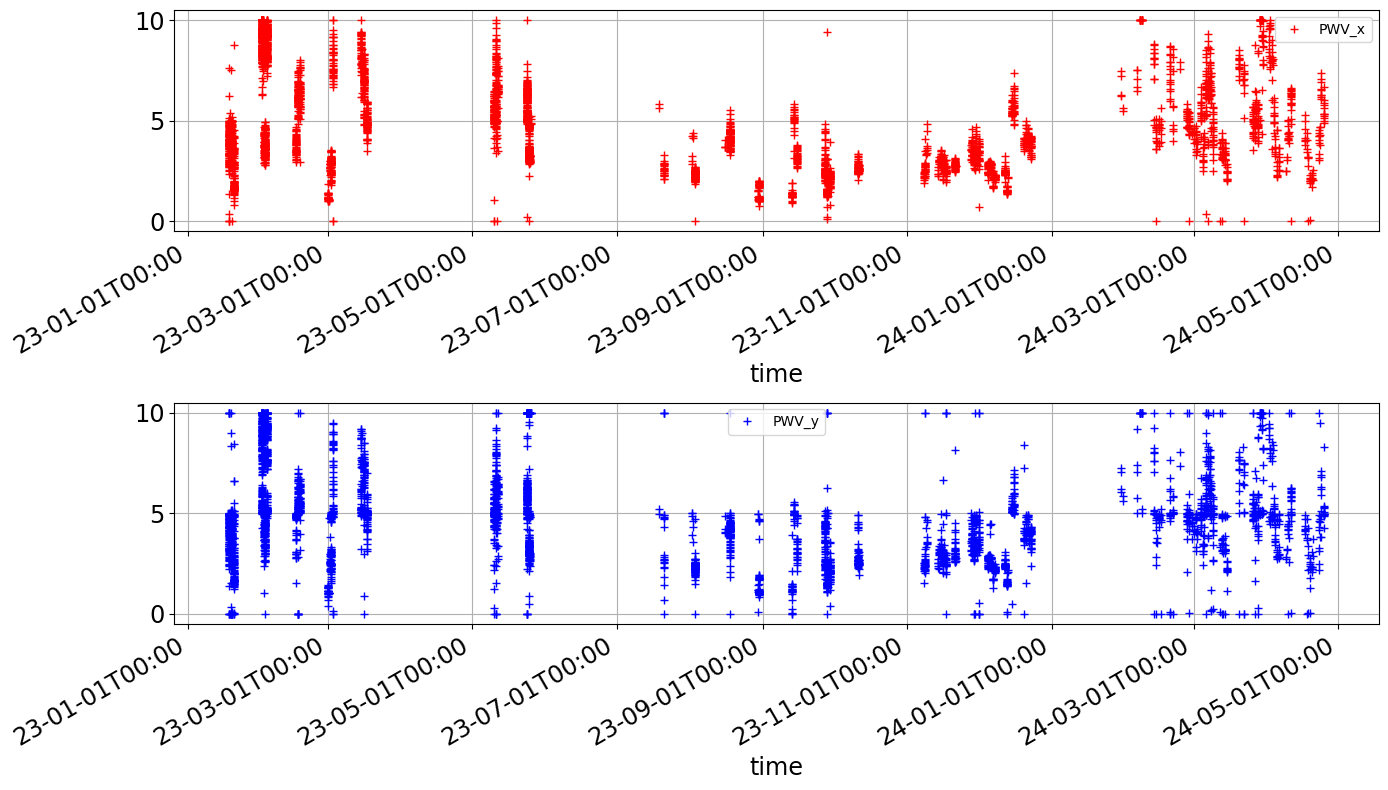

In [34]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8))
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="PWV_x")
df_spec.plot(x="Time",y="PWV [mm]_y",ax=ax2,marker='+',c="b",lw=0.0,grid=True,label="PWV_y")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)
plt.tight_layout()

## Photometry

#### read list of all possible pairs

In [35]:
df_pair = pd.read_csv("all_pairs.csv",index_col=0)
df_pair.head()

,objidx1,objidx2,G1_R1,G2_R2,Z1_Y1,Z2_Y2,sep
606,141.0,907.0,0.735042,0.980283,-0.114436,NaN,7.953708
2060,654.0,669.0,0.331201,0.533893,0.007770,-0.191827,10.576831
333,111.0,262.0,0.540740,0.144065,-0.112162,0.005726,16.129314
2152,813.0,950.0,0.864215,1.371627,-0.175939,NaN,16.859074
18,64.0,262.0,0.480447,0.144065,-0.094639,0.005726,18.288013


Text(0.5, 1.0, 'Bright sources angular correlation in tract 3864')

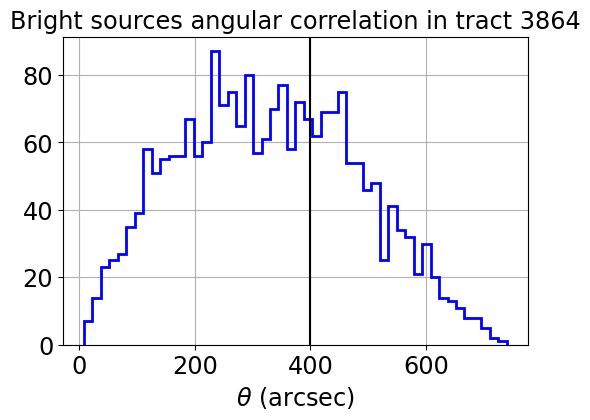

In [36]:
fig,axs = plt.subplots(1,1,figsize=(6,4))
ax1 = axs
df_pair["sep"].hist(bins=50,ax=ax1,histtype="step",color="b",lw=2);
image_size = 0.1*4000.
ax1.axvline(image_size,color="k")
ax1.set_xlabel("$\\theta$ (arcsec)")
ax1.set_title(f"Bright sources angular correlation in tract {tract}")


#### Select the pair to study

In [37]:
idx_pair = 9
objectname1 = int(df_pair["objidx1"].iloc[idx_pair])
objectname2 = int(df_pair["objidx2"].iloc[idx_pair])

In [38]:
df_pair.iloc[idx_pair]

objidx1    538.000000
objidx2    550.000000
G1_R1        0.004450
G2_R2        0.330682
Z1_Y1       -0.007838
Z2_Y2       -0.082057
sep         26.496769
Name: 1777, dtype: float64

### Read All sources from all objects 

In [39]:
#inputfilename = "sources_objectTable-t3864-multibands-o912-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv"

## The two lists:
path_photom ="data/photom/sources_objectTable"
tract = 3864

#inputfilename ="objects-lightcurves-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069-tract3864.csv"
inputfilename = "objects-lightcurves-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146-tract3864.csv"
inputfullfilename= os.path.join(path_photom,inputfilename) 

df_allsources = pd.read_csv(inputfullfilename,index_col=0)


In [40]:
df_allsources.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,apFlux_50_0_calFlux,apFlux_50_0_calFluxErr,apFlux_50_0_calMag,apFlux_50_0_calMagErr,psfInstMag,psfInstMagErr,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas,localPhotoCalibMag,localPhotoCalibMagErr,DZP
0,179300073413279748,1.580155e+06,12859.257891,False,1.024903,0.0,0.0,True,False,1.623147e+06,16479.172165,False,44.601713,0.08864,False,3,2023121500478,0,122.616310,-36.190488,SDSSz_65mm~empty,z,35950.336609,617.848502,3577.161510,50.744821,37540.276080,870.651651,False,0.283571,False,3,520,122.880748,15.903251,0.008836,1.603447e+06,27557.101564,15.887364,0.018660,1.674361e+06,38832.555057,15.840377,0.025181,20.026629,0.008836,0.973513,42748468736,2023121500478,z,21.00044,27.29522,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.051613,-0.051273,-289.071008,-6.930543,41.679035,-14.658130,16.119924,27.276621,0.002158,-0.018598
1,179300073413279762,1.722274e+06,13896.409761,False,1.008761,0.0,0.0,True,False,1.720439e+06,15854.387410,False,43.825502,0.08864,False,17,2023121500478,0,122.585459,-36.189035,SDSSz_65mm~empty,z,38142.817947,714.174432,2641.422054,117.690518,36449.190848,1007.305025,False,-0.155558,False,17,270,123.936603,15.809745,0.008760,1.671628e+06,31299.052698,15.842151,0.020329,1.597404e+06,44145.647972,15.891463,0.030005,19.914062,0.008760,1.001067,42748468736,2023121500478,z,21.00044,27.29522,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.020762,-0.049820,-190.569969,-6.295061,-2.146178,-3.282275,-4.634251,27.295683,0.002196,0.000463
2,179300073413279801,1.061165e+07,34913.067517,False,1.015366,0.0,0.0,True,False,1.067569e+07,39481.891718,False,44.669276,0.08864,False,56,2023121500478,0,122.614697,-36.183513,SDSSz_65mm~empty,z,236933.203217,805.869427,3531.742421,313.696491,241064.481355,1040.035058,False,1.082012,False,56,654,303.944893,13.835543,0.003572,1.058363e+07,35997.603672,13.838413,0.003693,1.076818e+07,46457.612786,13.819645,0.004684,17.960565,0.003572,0.994001,42748468736,2023121500478,z,21.00044,27.29522,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.2

#### Select all sources/visits corresponding to object1/object2 respectively

In [41]:
df_myselectedvisits1 = df_allsources[df_allsources.obj_index==objectname1] 	
df_myselectedvisits2 = df_allsources[df_allsources.obj_index==objectname2] 	

In [42]:
df_myselectedvisits1.sort_values("visit",inplace=True)
df_myselectedvisits2.sort_values("visit",inplace=True)
#df_myselectedvisits.sort_index(inplace=True)

In [43]:
df_myselectedvisits1.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,apFlux_50_0_calFlux,apFlux_50_0_calFluxErr,apFlux_50_0_calMag,apFlux_50_0_calMagErr,psfInstMag,psfInstMagErr,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas,localPhotoCalibMag,localPhotoCalibMagErr,DZP
8554,178244580905320570,2.731367e+07,43544.216081,False,1.006927,0.0,0.0,True,True,2.749383e+07,50886.479372,False,24.730200,0.026076,False,121,2023111500514,0,122.440299,-36.225330,empty~SDSSi_65mm,i,1.111154e+06,1186.643975,1715.673429,407.625536,1.132634e+06,1349.789168,False,4.395319,False,121,538,627.262888,12.809050,0.001731,2.747907e+07,29345.942503,12.802495,0.001159,2.801026e+07,33380.555713,12.781707,0.001294,16.292119,0.001731,0.993447,42496819712,2023111500514,i,19.375599,27.910023,4.441452,11.639739,8.028997,0.006775,0.006775,99,0.004106,-0.002054,0.019813,0.017316,-0.002933,0.065246,0.014666,0.789290,1327.82500,0.926883,0.050693,2.577377,0.236470,-36.182908,0,1.000873,359.999751,2023-11-16 07:44:48.206501,60264.322780,30.0,2023-11-16 07:44:33.206501,60264.322607,30.2373,4071,3999,122.383919,-36.236743,122.518100,-36.235360,122.516314,-36.129036,122.382314,-36.130417,1.060036,0.004591,-0.009863,-0.042422,-9.296620,-3.713617,-1.965137,-3.849201,-7.643914,27.916931,0.001145,0.006908
32083,178244631371186443,2.736703e+07,53900.239739,False,1.005296,0.0,0.0,True,True,2.752842e+07,59155.702546,False,26.349023,0.040879,False,266,2023111500561,0,122.440299,-36.225331,SDSSr_65mm~empty,r,1.057177e+06,1187.970267,2356.875721,1873.576288,1.086374e+06,1367.944482,False,2.340834,False,266,538,507.734907,12.806931,0.002138,2.785558e+07,31301.855299,12.787720,0.001220,2.862489e+07,36043.999948,12.758140,0.001367,16.358842,0.002138,0.994137,42496831744,2023111500561,r,10.282602,27.850636,6.108496,7.000794,7.798053,0.012533,0.012533,66,0.000937,0.001972,0.010871,0.015003,0.007884,0.071531,0.011698,0.544651,860.74475,0.730284,0.026800,4.285229,0.211966,-36.222094,0,1.376556,359.999817,2023-11-16 08:33:05.921996,60264.356319,30.0,2023-11-16 08:32:50.921996,60264.356145,30.2278,4071,3999,122.363392,-36.275942,122.497633,-36.274543,122.495832,-36.168210,122.361773,-36.169608,1.016323,0.002183,0.010642,-0.003237,-11.415743,-4.076112,-2.525982,-5.881146,-10.662446,27.848089,0.001684,-0.002547
25140,178279885536493767,2.782399e+07,60835.167944,False,1.046028,0.0,0.0,True,True,2.789483e+07,65853.277265,False,26.718404,0.048756,False,198,2023111600626,0,122.440301,-36.225330,empty~SDSSi_65mm,i,1.062858e+06,1187.010636,1048.673079,1675.098831,1.108382e+06,1376.899227,False,1.952200,False,198,538,457.366935,12.788951,0.002374,2.839786e+07,31715.030100,12.766786,0.001213,2.961419e+07,36788.550259,12.721250,0.001349,16.355978,0.002374,0.997460,42505236992,2023111600626,i,27.384230,27.833578,8.026257,14.813572,8.229633,0.019546,0.019546,31,-0.000095,-0.007637,0.021009,0.014181,0.132348,0.0644

In [44]:
df_myselectedvisits2.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,apFlux_50_0_calFlux,apFlux_50_0_calFluxErr,apFlux_50_0_calMag,apFlux_50_0_calMagErr,psfInstMag,psfInstMagErr,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas,localPhotoCalibMag,localPhotoCalibMagErr,DZP
8744,178244578757836857,3.934062e+06,13670.577572,False,0.998651,0.0,0.0,True,False,3.917811e+06,16159.489515,False,21.607945,0.033635,False,56,2023111500512,0,122.447686,-36.220994,SDSSg_65mm~empty,g,185622.294325,730.983628,1952.604964,566.695413,188782.514133,954.188340,False,0.311713,False,56,550,287.775822,14.912897,0.003773,4.010916e+06,15795.053962,14.891891,0.004276,4.079202e+06,20618.049075,14.873562,0.005488,18.249431,0.003773,1.004148,42496819200,2023111500512,g,19.689250,28.055744,5.060759,2.841207,7.533664,0.008979,0.008979,55,-0.001041,-0.004034,0.018226,0.026834,0.016407,0.075121,0.014870,0.984311,1687.2689,3.825267,0.039045,10.558892,0.309281,-36.182875,0,1.140550,359.999685,2023-11-16 07:43:13.140509,60264.321680,30.0,2023-11-16 07:42:58.140509,60264.321506,30.2349,4071,3999,122.383562,-36.236717,122.517753,-36.235335,122.515966,-36.128996,122.381956,-36.130377,1.062097,0.004166,-0.002123,-0.038119,353.756688,29.235268,-1.461528,8.119821,8.134726,28.063466,0.001690,0.007722
29952,178244585200287787,3.907143e+06,14518.389945,False,1.018184,0.0,0.0,True,False,3.914365e+06,16745.240908,False,21.836015,0.041189,False,42,2023111500518,0,122.447686,-36.220999,SDSSg_65mm~empty,g,181078.874865,760.986002,844.818526,581.868533,185711.835124,1005.958357,False,0.211817,False,42,550,269.116825,14.920352,0.004034,3.954041e+06,16616.901444,14.907397,0.004563,4.055206e+06,21966.121376,14.879968,0.005881,18.268285,0.004034,0.998155,42496820736,2023111500518,g,18.486301,28.043776,6.226140,2.821023,7.532186,0.011670,0.011670,41,0.003544,-0.002417,0.015417,0.016089,-0.007696,0.057003,0.009045,0.651877,1471.1619,2.489869,0.025797,10.634441,0.302537,-36.182914,0,1.403211,359.999619,2023-11-16 07:49:26.978505,60264.326007,30.0,2023-11-16 07:49:11.978505,60264.325833,30.2392,4071,3999,122.420069,-36.236755,122.554263,-36.235376,122.552465,-36.129036,122.418453,-36.130413,1.054408,0.004290,-0.038626,-0.038085,361.211337,29.645301,-0.669642,-9.171204,-13.061952,28.052067,0.002048,0.008291
8687,178244586274029628,5.367026e+06,17703.100746,False,1.021146,0.0,0.0,True,True,5.395284e+06,21294.350809,False,26.777698,0.036806,False,59,2023111500519,0,122.447685,-36.220999,SDSSr_65mm~empty,r,203873.437879,776.399231,844.893968,582.959859,210351.469151,1020.131742,False,0.346822,False,59,550,303.168715,14.575666,0.003581,5.459261e+06,20790.184246,14.557165,0.004135,5.632728e+06,27316.779865,14.523203,0.005265,18.145099,0.003581,0.994762,42496820992,2023111500519,r,18.333109,27.832073,6.455510,4.576701,7.654831,0.011991,0.011991,62,-0.000330,-0.003027,0.017506,0.018060,0.005565,0.120819,0.01

### Compute nightobs and Times (pd.to_datetime)

In [45]:
df_myselectedvisits1["nightObs"] = df_myselectedvisits1.apply(lambda x: x['visit']//100_000 , axis=1)
df_myselectedvisits1["Time"] = pd.to_datetime(df_myselectedvisits1['obsStart'])

In [46]:
pd.to_datetime(df_myselectedvisits2['obsStart']).to_frame()

,obsStart
8744,2023-11-16 07:42:58.140509
29952,2023-11-16 07:49:11.978505
8687,2023-11-16 07:49:58.642008
9561,2023-11-16 08:29:04.791991
32067,2023-11-16 08:32:04.480505
...,...
74629,2024-04-23 02:35:57.697497
67085,2024-04-23 02:36:46.285491
74729,2024-04-23 02:38:25.021505
74778,2024-04-23 02:40:10.736999


In [47]:
df_myselectedvisits2.loc[:,"nightObs"] = df_myselectedvisits2.apply(lambda x: x['visit']//100_000 , axis=1,result_type='expand')
df_myselectedvisits2.loc[:,"Time"] = pd.to_datetime(df_myselectedvisits2['obsStart']).to_frame()

### Split list by bands

In [48]:
df_myselectedvisits_g1 = df_myselectedvisits1[df_myselectedvisits1.band == "g"]
df_myselectedvisits_r1 = df_myselectedvisits1[df_myselectedvisits1.band == "r"]
df_myselectedvisits_z1 = df_myselectedvisits1[df_myselectedvisits1.band == "z"]
df_myselectedvisits_y1 = df_myselectedvisits1[df_myselectedvisits1.band == "y"]

df_myselectedvisits_g2 = df_myselectedvisits2[df_myselectedvisits2.band == "g"]
df_myselectedvisits_r2 = df_myselectedvisits2[df_myselectedvisits2.band == "r"]
df_myselectedvisits_z2 = df_myselectedvisits2[df_myselectedvisits2.band == "z"]
df_myselectedvisits_y2 = df_myselectedvisits2[df_myselectedvisits2.band == "y"]

In [49]:
df_myselectedvisits_z1[["nightObs","visit"]].head() 

,nightObs,visit
28569,20231121,2023112100544
29527,20231121,2023112100596
43519,20231127,2023112700295
45871,20231127,2023112700395
512,20231129,2023112900635


In [50]:
df_myselectedvisits_z2[["nightObs","visit"]].head() 

,nightObs,visit
27906,20231121,2023112100508
28035,20231121,2023112100516
29506,20231121,2023112100600
45873,20231127,2023112700395
46026,20231127,2023112700399


In [51]:
# no 2023112100507 in z
df_myselectedvisits_y1[["nightObs","visit"]].head() 

,nightObs,visit
67400,20231121,2023112100509
11974,20231121,2023112100537
28593,20231121,2023112100545
29446,20231121,2023112100597
43545,20231127,2023112700296


In [52]:
df_myselectedvisits_y2[["nightObs","visit"]].head() 

,nightObs,visit
67403,20231121,2023112100509
67473,20231121,2023112100513
67702,20231121,2023112100533
11977,20231121,2023112100537
28833,20231121,2023112100549


### Merge visits in same band/same calexp for object 1 and Object 2 

In [53]:
df_y = df_myselectedvisits_y1.merge(df_myselectedvisits_y2, left_on='visit', right_on='visit',how="inner")
df_z = df_myselectedvisits_z1.merge(df_myselectedvisits_z2, left_on='visit', right_on='visit',how="inner")
df_g = df_myselectedvisits_g1.merge(df_myselectedvisits_g2, left_on='visit', right_on='visit',how="inner")
df_r = df_myselectedvisits_r1.merge(df_myselectedvisits_r2, left_on='visit', right_on='visit',how="inner")

In [54]:
df_z["visit"].head(n=5)

0    2023112700395
1    2023120600238
2    2023121100521
3    2023122200479
4    2024021900267
Name: visit, dtype: int64

In [55]:
df_y["visit"].head(n=5)

0    2023112100509
1    2023112100537
2    2023112100597
3    2023112700296
4    2023112700300
Name: visit, dtype: int64

### Distance in pixels

In [56]:
df_y["dx"] = df_y['x_x'] - df_y['x_y']
df_y["dy"] = df_y['y_x'] - df_y['y_y']
df_y["dpix"] = np.sqrt(df_y["dx"]**2 + df_y["dy"]**2)

Text(0.5, 0, 'distance in pixels')

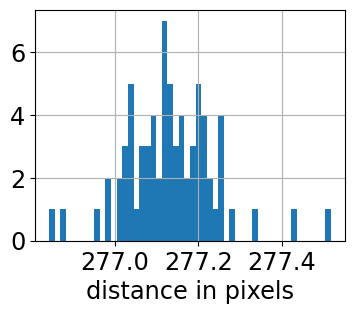

In [57]:
df_y["dpix"].hist(bins=50)
plt.xlabel("distance in pixels")

## Distance in time between the pairs

In [58]:
df_y["dt"] = (df_y['expMidptMJD_x'] - df_y['expMidptMJD_y'])*3600*24

<Axes: >

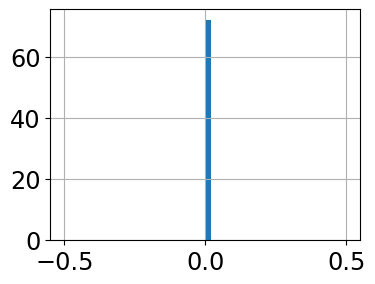

In [59]:
df_y["dt"].hist(bins=50)

In [60]:
# convert timedelta into seconds
# thus it confirms the exposure is the same
df_y["dTime"] = pd.to_timedelta(df_y['Time_x'] - df_y['Time_y']).dt.seconds

<Axes: >

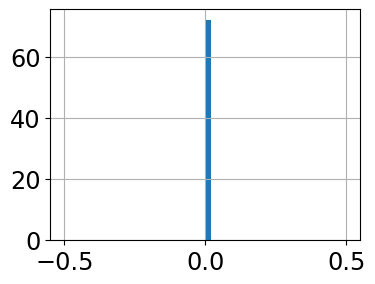

In [61]:
df_y["dTime"].hist(bins=50)

## Rename quantities supposed to be the same as same visit

In [62]:
df_y["band"] = df_y["band_x"]
df_z["band"] = df_z["band_x"]
df_g["band"] = df_g["band_x"]
df_r["band"] = df_r["band_x"]

df_y["Time"] = df_y["Time_x"]
df_z["Time"] = df_z["Time_x"]
df_g["Time"] = df_g["Time_x"]
df_r["Time"] = df_r["Time_x"]

df_y["nightObs"] = df_y["nightObs_x"]
df_z["nightObs"] = df_z["nightObs_x"]
df_g["nightObs"] = df_g["nightObs_x"]
df_r["nightObs"] = df_r["nightObs_x"]

#df_y["visit"] = df_y["visit_x"]
#df_z["visit"] = df_z["visit_x"]
#df_g["visit"] = df_g["visit_x"]
#df_r["visit"] = df_r["visit_x"]

df_y["expMidptMJD"] = df_y["expMidptMJD_x"]
df_z["expMidptMJD"] = df_z["expMidptMJD_x"]
df_g["expMidptMJD"] = df_g["expMidptMJD_x"]
df_r["expMidptMJD"] = df_r["expMidptMJD_x"]

## Difference in magnitudes between the pairs

#### psf Magnitude

In [63]:
df_y["dpsfMag"] = df_y["psfMag_x"] -  df_y["psfMag_y"]
df_z["dpsfMag"] = df_z["psfMag_x"] -  df_z["psfMag_y"]
df_g["dpsfMag"] = df_g["psfMag_x"] -  df_g["psfMag_y"]
df_r["dpsfMag"] = df_r["psfMag_x"] -  df_r["psfMag_y"]

In [64]:
df_y["dpsfInstMag"] = df_y["psfInstMag_x"] -  df_y["psfInstMag_y"]
df_z["dpsfInstMag"] = df_z["psfInstMag_x"] -  df_z["psfInstMag_y"]
df_g["dpsfInstMag"] = df_g["psfInstMag_x"] -  df_g["psfInstMag_y"]
df_r["dpsfInstMag"] = df_r["psfInstMag_x"] -  df_r["psfInstMag_y"]

In [65]:
df_y["dpsfMagErr"] = np.sqrt(df_y["psfMagErr_x"]**2 +  df_y["psfMagErr_y"]**2) 
df_z["dpsfMagErr"] = np.sqrt(df_z["psfMagErr_x"]**2 +  df_z["psfMagErr_y"]**2) 
df_g["dpsfMagErr"] = np.sqrt(df_g["psfMagErr_x"]**2 +  df_g["psfMagErr_y"]**2) 
df_r["dpsfMagErr"] = np.sqrt(df_r["psfMagErr_x"]**2 +  df_r["psfMagErr_y"]**2) 

In [66]:
df_y["dpsfInstMagErr"] = np.sqrt(df_y["psfInstMagErr_x"]**2 +  df_y["psfInstMagErr_y"]**2) 
df_z["dpsfInstMagErr"] = np.sqrt(df_z["psfInstMagErr_x"]**2 +  df_z["psfInstMagErr_y"]**2) 
df_g["dpsfInstMagErr"] = np.sqrt(df_g["psfInstMagErr_x"]**2 +  df_g["psfInstMagErr_y"]**2) 
df_r["dpsfInstMagErr"] = np.sqrt(df_r["psfInstMagErr_x"]**2 +  df_r["psfInstMagErr_y"]**2) 

#### Aperture Magnitude

In [67]:
df_y["dapFlux_35_0_calMag"] = df_y["apFlux_35_0_calMag_x"] - df_y["apFlux_35_0_calMag_y"]
df_z["dapFlux_35_0_calMag"] = df_z["apFlux_35_0_calMag_x"] - df_z["apFlux_35_0_calMag_y"]
df_g["dapFlux_35_0_calMag"] = df_g["apFlux_35_0_calMag_x"] - df_g["apFlux_35_0_calMag_y"]
df_r["dapFlux_35_0_calMag"] = df_r["apFlux_35_0_calMag_x"] - df_r["apFlux_35_0_calMag_y"]

In [68]:
df_y["dapFlux_35_0_calMagErr"] = np.sqrt(df_y["apFlux_35_0_calMagErr_x"]**2 + df_y["apFlux_35_0_calMagErr_y"]**2)
df_z["dapFlux_35_0_calMagErr"] = np.sqrt(df_z["apFlux_35_0_calMagErr_x"]**2 + df_z["apFlux_35_0_calMagErr_y"]**2)
df_g["dapFlux_35_0_calMagErr"] = np.sqrt(df_g["apFlux_35_0_calMagErr_x"]**2 + df_g["apFlux_35_0_calMagErr_y"]**2)
df_r["dapFlux_35_0_calMagErr"] = np.sqrt(df_r["apFlux_35_0_calMagErr_x"]**2 + df_r["apFlux_35_0_calMagErr_y"]**2)

In [69]:
df_y["dapFlux_50_0_calMag"] = df_y["apFlux_50_0_calMag_x"] - df_y["apFlux_50_0_calMag_y"]
df_z["dapFlux_50_0_calMag"] = df_z["apFlux_50_0_calMag_x"] - df_z["apFlux_50_0_calMag_y"]
df_g["dapFlux_50_0_calMag"] = df_g["apFlux_50_0_calMag_x"] - df_g["apFlux_50_0_calMag_y"]
df_r["dapFlux_50_0_calMag"] = df_r["apFlux_50_0_calMag_x"] - df_r["apFlux_50_0_calMag_y"]

In [70]:
df_y["dapFlux_50_0_calMagErr"] = np.sqrt(df_y["apFlux_50_0_calMagErr_x"]**2 + df_y["apFlux_50_0_calMagErr_y"]**2)
df_z["dapFlux_50_0_calMagErr"] = np.sqrt(df_z["apFlux_50_0_calMagErr_x"]**2 + df_z["apFlux_50_0_calMagErr_y"]**2)
df_g["dapFlux_50_0_calMagErr"] = np.sqrt(df_g["apFlux_50_0_calMagErr_x"]**2 + df_g["apFlux_50_0_calMagErr_y"]**2)
df_r["dapFlux_50_0_calMagErr"] = np.sqrt(df_r["apFlux_50_0_calMagErr_x"]**2 + df_r["apFlux_50_0_calMagErr_y"]**2)

### Relative magnitude difference

In [71]:
df_y["d_psfMag"] = df_y["dpsfMag"] - df_y["dpsfMag"].mean()
df_z["d_psfMag"] = df_z["dpsfMag"] - df_z["dpsfMag"].mean()
df_g["d_psfMag"] = df_g["dpsfMag"] - df_g["dpsfMag"].mean()
df_r["d_psfMag"] = df_r["dpsfMag"] - df_r["dpsfMag"].mean()

In [72]:
df_y["d_psfInstMag"] = df_y["dpsfInstMag"] - df_y["dpsfInstMag"].mean()
df_z["d_psfInstMag"] = df_z["dpsfInstMag"] - df_z["dpsfInstMag"].mean()
df_g["d_psfInstMag"] = df_g["dpsfInstMag"] - df_g["dpsfInstMag"].mean()
df_r["d_psfInstMag"] = df_r["dpsfInstMag"] - df_r["dpsfInstMag"].mean()

In [73]:
df_y["d_apFlux_35_0_calMag"] = df_y["dapFlux_35_0_calMag"] - df_y["dapFlux_35_0_calMag"].mean()
df_z["d_apFlux_35_0_calMag"] = df_z["dapFlux_35_0_calMag"] - df_z["dapFlux_35_0_calMag"].mean()
df_g["d_apFlux_35_0_calMag"] = df_g["dapFlux_35_0_calMag"] - df_g["dapFlux_35_0_calMag"].mean()
df_r["d_apFlux_35_0_calMag"] = df_r["dapFlux_35_0_calMag"] - df_r["dapFlux_35_0_calMag"].mean()

In [74]:
df_y["d_apFlux_50_0_calMag"] = df_y["dapFlux_50_0_calMag"] - df_y["dapFlux_50_0_calMag"].mean()
df_z["d_apFlux_50_0_calMag"] = df_z["dapFlux_50_0_calMag"] - df_z["dapFlux_50_0_calMag"].mean()
df_g["d_apFlux_50_0_calMag"] = df_g["dapFlux_50_0_calMag"] - df_g["dapFlux_50_0_calMag"].mean()
df_r["d_apFlux_50_0_calMag"] = df_r["dapFlux_50_0_calMag"] - df_r["dapFlux_50_0_calMag"].mean()

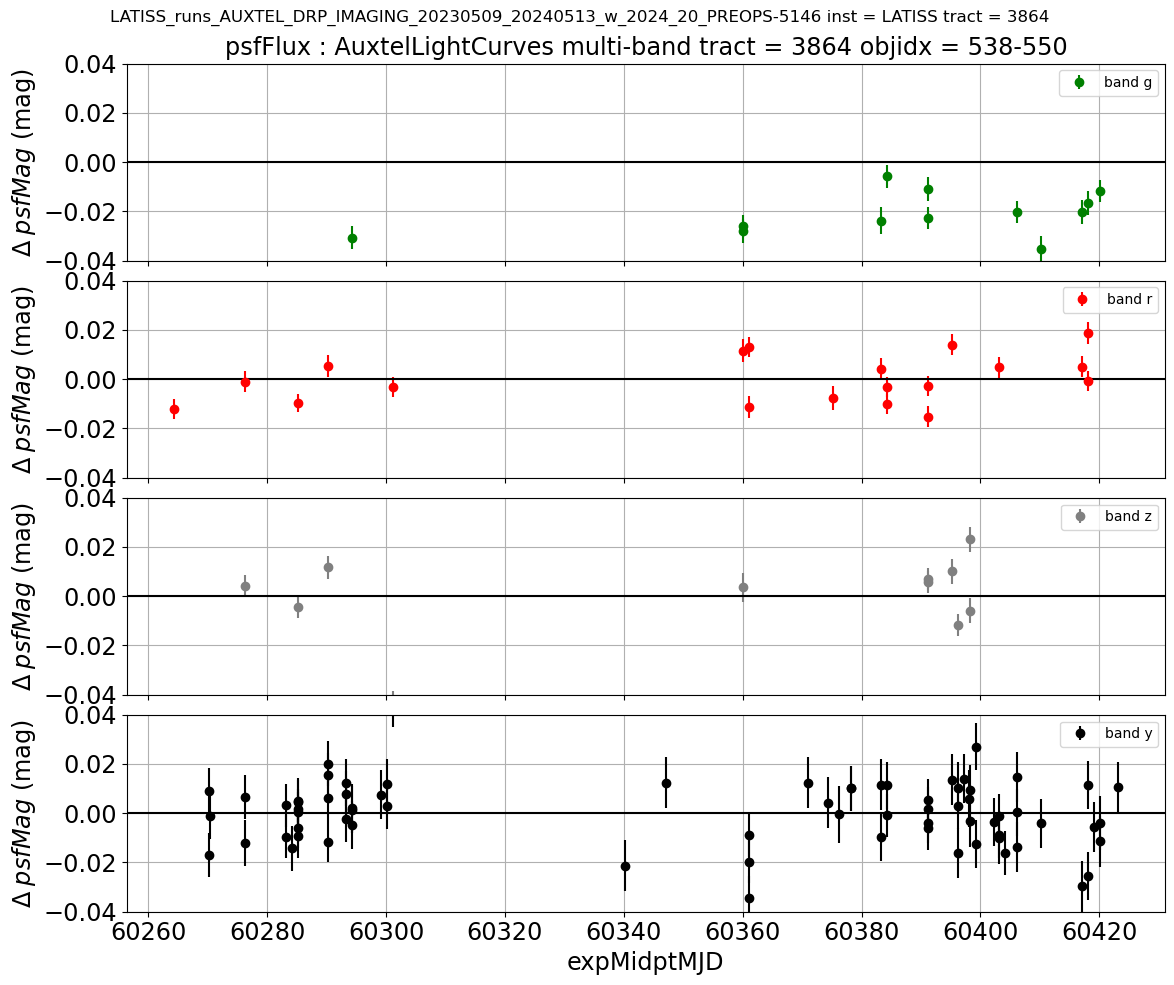

In [75]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)
title = f"psfFlux : AuxtelLightCurves multi-band tract = {tract} objidx = {objectname1}-{objectname2}"
ax1.errorbar(df_g.expMidptMJD,df_g.d_psfMag,yerr=df_g.dpsfMagErr,fmt="o",color="g",label="band g")
ax1.set_title(title)
ax2.errorbar(df_r.expMidptMJD,df_r.d_psfMag,yerr=df_r.dpsfMagErr,fmt="o",color="r",label="band r")
ax3.errorbar(df_z.expMidptMJD,df_z.d_psfMag,yerr=df_z.dpsfMagErr,fmt="o",color="grey",label="band z")
ax4.errorbar(df_y.expMidptMJD,df_y.d_psfMag,yerr=df_y.dpsfMagErr,fmt="o",color="k",label="band y")
#df_r.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax2,s=20,c="zeroPoint_x",cmap="jet",label="band r",grid=True,rot=45)
#df_z.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax3,s=20,c="zeroPoint_x",cmap="jet",label="band z",grid=True,rot=45)
#df_y.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax4,s=20,c="zeroPoint_x",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
#ax4.tick_params(labelbottom=True)
ax1.set_ylim(-0.04,0.04)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax4.set_xlabel("expMidptMJD")
ax1.set_ylabel("$\Delta \; psfMag$ (mag)")
ax2.set_ylabel("$\Delta \; psfMag$ (mag)")
ax3.set_ylabel("$\Delta \; psfMag$ (mag)")
ax4.set_ylabel("$\Delta \; psfMag$ (mag)")
ax1.axhline(0,color="k")
ax2.axhline(0,color="k")
ax3.axhline(0,color="k")
ax4.axhline(0,color="k")
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

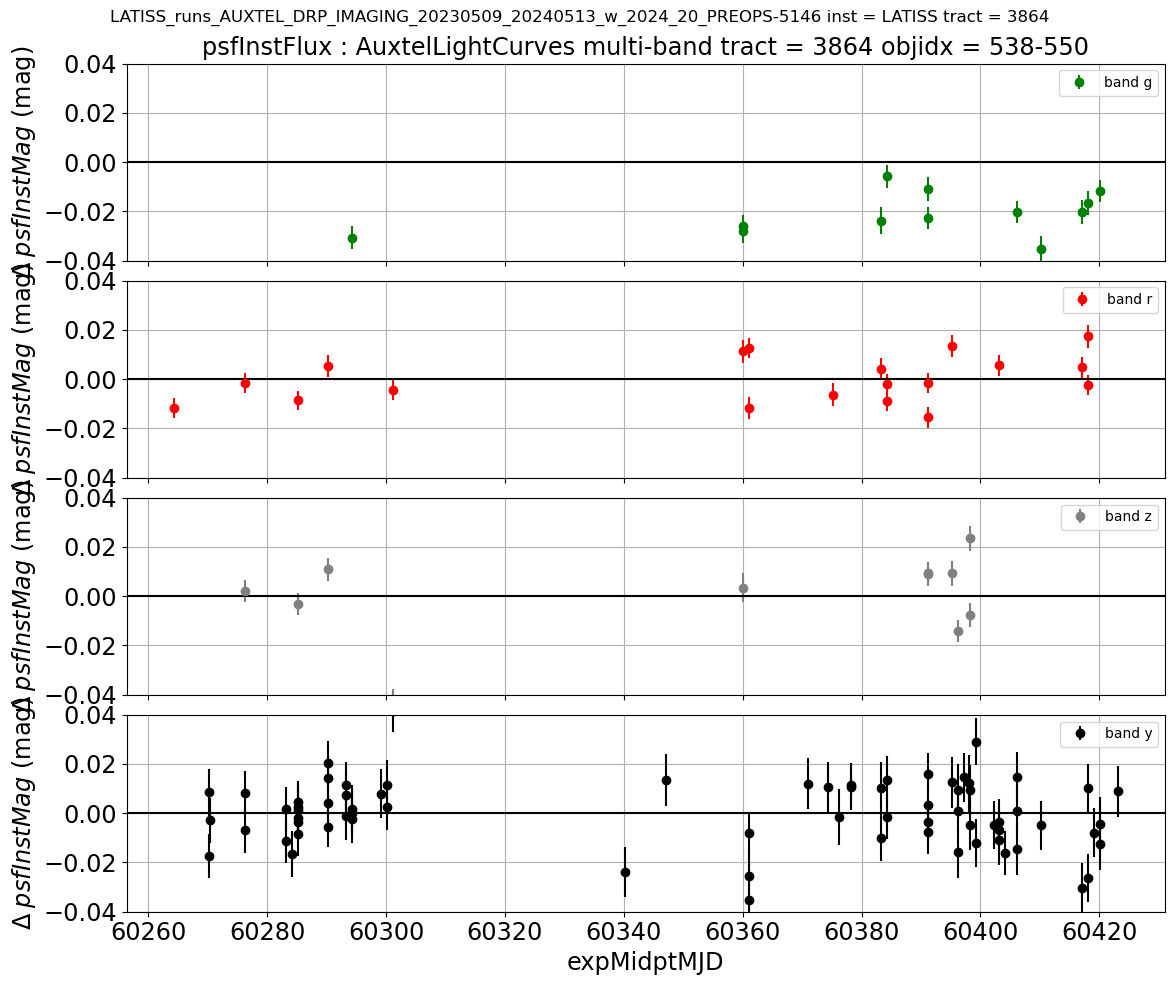

In [76]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)
title = f"psfInstFlux : AuxtelLightCurves multi-band tract = {tract} objidx = {objectname1}-{objectname2}"
ax1.errorbar(df_g.expMidptMJD,df_g.d_psfMag,yerr=df_g.dpsfMagErr,fmt="o",color="g",label="band g")
ax1.set_title(title)
ax2.errorbar(df_r.expMidptMJD,df_r.d_psfInstMag,yerr=df_r.dpsfMagErr,fmt="o",color="r",label="band r")
ax3.errorbar(df_z.expMidptMJD,df_z.d_psfInstMag,yerr=df_z.dpsfMagErr,fmt="o",color="grey",label="band z")
ax4.errorbar(df_y.expMidptMJD,df_y.d_psfInstMag,yerr=df_y.dpsfMagErr,fmt="o",color="k",label="band y")
#df_r.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax2,s=20,c="zeroPoint_x",cmap="jet",label="band r",grid=True,rot=45)
#df_z.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax3,s=20,c="zeroPoint_x",cmap="jet",label="band z",grid=True,rot=45)
#df_y.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax4,s=20,c="zeroPoint_x",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
#ax4.tick_params(labelbottom=True)
ax1.set_ylim(-0.04,0.04)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax4.set_xlabel("expMidptMJD")
ax1.set_ylabel("$\Delta \; psfInstMag$ (mag)")
ax2.set_ylabel("$\Delta \; psfInstMag$ (mag)")
ax3.set_ylabel("$\Delta \; psfInstMag$ (mag)")
ax4.set_ylabel("$\Delta \; psfInstMag$ (mag)")
ax1.axhline(0,color="k")
ax2.axhline(0,color="k")
ax3.axhline(0,color="k")
ax4.axhline(0,color="k")
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

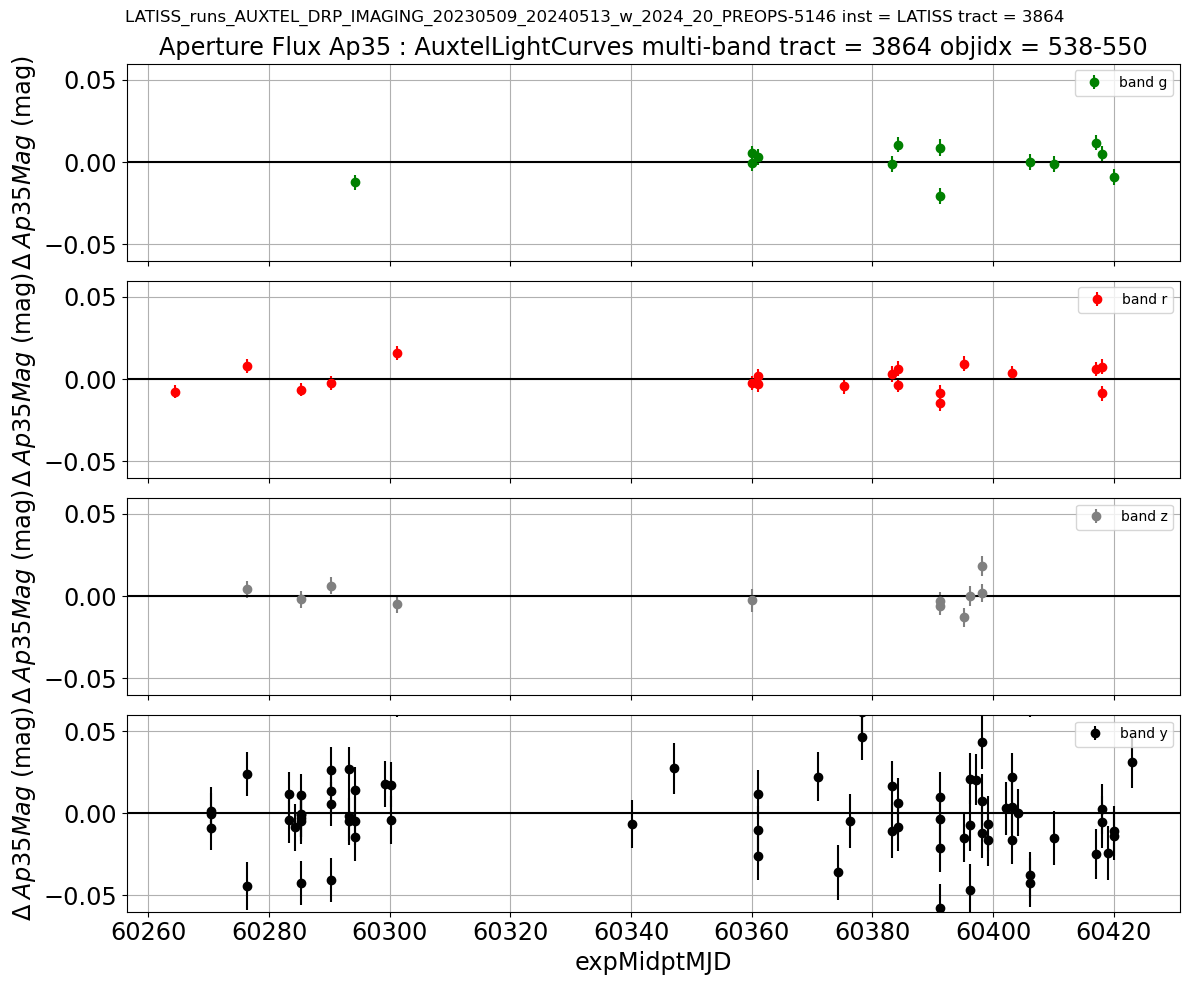

In [77]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)
title = f"Aperture Flux Ap35 : AuxtelLightCurves multi-band tract = {tract} objidx = {objectname1}-{objectname2}"
ax1.errorbar(df_g.expMidptMJD,df_g.d_apFlux_35_0_calMag,yerr=df_g.dapFlux_35_0_calMagErr,fmt="o",color="g",label="band g")
ax1.set_title(title)
ax2.errorbar(df_r.expMidptMJD,df_r.d_apFlux_35_0_calMag,yerr=df_r.dapFlux_35_0_calMagErr,fmt="o",color="r",label="band r")
ax3.errorbar(df_z.expMidptMJD,df_z.d_apFlux_35_0_calMag,yerr=df_z.dapFlux_35_0_calMagErr,fmt="o",color="grey",label="band z")
ax4.errorbar(df_y.expMidptMJD,df_y.d_apFlux_35_0_calMag,yerr=df_y.dapFlux_35_0_calMagErr,fmt="o",color="k",label="band y")
#df_r.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax2,s=20,c="zeroPoint_x",cmap="jet",label="band r",grid=True,rot=45)
#df_z.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax3,s=20,c="zeroPoint_x",cmap="jet",label="band z",grid=True,rot=45)
#df_y.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax4,s=20,c="zeroPoint_x",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
#ax4.tick_params(labelbottom=True)
ax1.set_ylim(-0.06,0.06)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.axhline(0,color="k")
ax2.axhline(0,color="k")
ax3.axhline(0,color="k")
ax4.axhline(0,color="k")
ax4.set_xlabel("expMidptMJD")
ax1.set_ylabel("$\Delta \; Ap35 Mag$ (mag)")
ax2.set_ylabel("$\Delta \; Ap35 Mag$ (mag)")
ax3.set_ylabel("$\Delta \; Ap35 Mag$ (mag)")
ax4.set_ylabel("$\Delta \; Ap35 Mag$ (mag)")
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

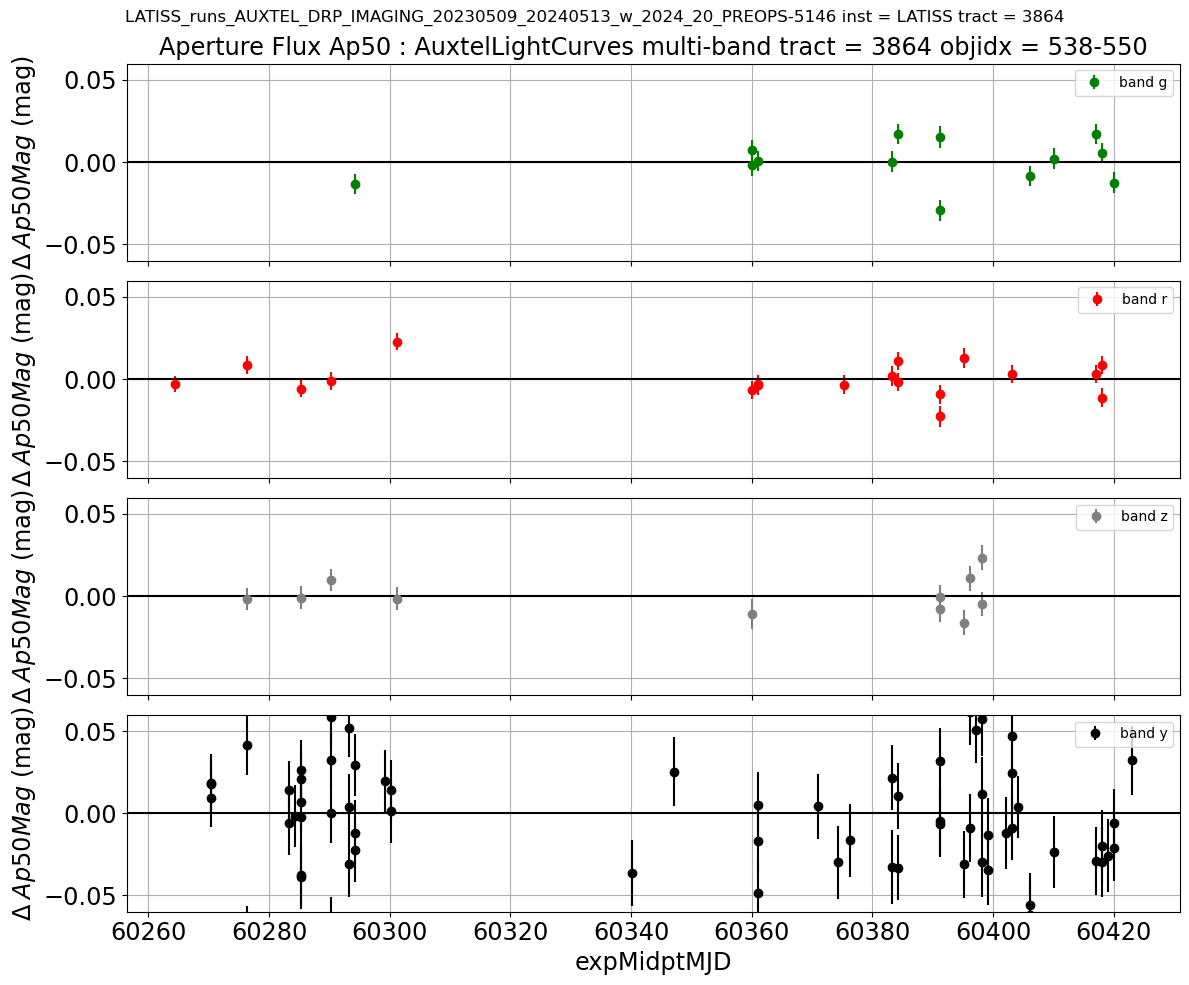

In [78]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)
title = f"Aperture Flux Ap50 : AuxtelLightCurves multi-band tract = {tract} objidx = {objectname1}-{objectname2}"
ax1.errorbar(df_g.expMidptMJD,df_g.d_apFlux_50_0_calMag,yerr=df_g.dapFlux_50_0_calMagErr,fmt="o",color="g",label="band g")
ax1.set_title(title)
ax2.errorbar(df_r.expMidptMJD,df_r.d_apFlux_50_0_calMag,yerr=df_r.dapFlux_50_0_calMagErr,fmt="o",color="r",label="band r")
ax3.errorbar(df_z.expMidptMJD,df_z.d_apFlux_50_0_calMag,yerr=df_z.dapFlux_50_0_calMagErr,fmt="o",color="grey",label="band z")
ax4.errorbar(df_y.expMidptMJD,df_y.d_apFlux_50_0_calMag,yerr=df_y.dapFlux_50_0_calMagErr,fmt="o",color="k",label="band y")
#df_r.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax2,s=20,c="zeroPoint_x",cmap="jet",label="band r",grid=True,rot=45)
#df_z.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax3,s=20,c="zeroPoint_x",cmap="jet",label="band z",grid=True,rot=45)
#df_y.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax4,s=20,c="zeroPoint_x",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
#ax4.tick_params(labelbottom=True)
ax1.set_ylim(-0.06,0.06)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax4.set_xlabel("expMidptMJD")
ax1.set_ylabel("$\Delta \; Ap50 Mag$ (mag)")
ax2.set_ylabel("$\Delta \; Ap50 Mag$ (mag)")
ax3.set_ylabel("$\Delta \; Ap50 Mag$ (mag)")
ax4.set_ylabel("$\Delta \; Ap50 Mag$ (mag)")
ax1.axhline(0,color="k")
ax2.axhline(0,color="k")
ax3.axhline(0,color="k")
ax4.axhline(0,color="k")
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

## Neighbouring visits

### band 1 : Group by NightObs and bands

In [79]:
groups_obs_size1 = df_myselectedvisits1.groupby(by=["nightObs","band"]).size()

In [80]:
groups_obs_size1

nightObs  band
20231115  i       1
          r       1
20231116  i       1
20231120  i       1
          r       1
                 ..
20240419  g       1
          y       2
          z       1
20240422  y       2
          z       1
Length: 128, dtype: int64

### band 1 : Group by NightObs and bands unstacked into a pandas dataframe

In [81]:
df_groups_obs_size1 = groups_obs_size1.unstack()
df_groups_obs_size1

band,g,i,r,y,z
nightObs,,,,,
20231115,NaN,1.0,1.0,NaN,NaN
20231116,NaN,1.0,NaN,NaN,NaN
20231120,NaN,1.0,1.0,NaN,NaN
20231121,NaN,NaN,1.0,4.0,2.0
20231127,1.0,NaN,2.0,3.0,2.0
20231129,NaN,NaN,1.0,2.0,1.0
20231130,NaN,NaN,NaN,1.0,NaN
20231204,NaN,NaN,NaN,2.0,1.0
20231205,NaN,NaN,2.0,4.0,3.0


### band 1 : Group by NightObs and band and Visit

In [82]:
groups_obs_visit1 = df_myselectedvisits1.groupby(by=["nightObs","band","visit"]).agg(time = ("Time","mean") ,psfMean = ("psfMag","mean"),apFlux_50_0_instFlux = ("apFlux_50_0_instFlux","mean"))
groups_obs_visit1 

time    psfMean  \
nightObs band visit                                                    
20231115 i    2023111500514 2023-11-16 07:44:33.206501120  12.809050   
         r    2023111500561 2023-11-16 08:32:50.921996032  12.806931   
20231116 i    2023111600626 2023-11-17 07:00:45.587502080  12.788951   
20231120 i    2023112000375 2023-11-21 08:25:36.898490112  12.847311   
         r    2023112000374 2023-11-21 08:24:48.475009024  12.832060   
...                                                   ...        ...   
20240419 y    2024041900359 2024-04-20 02:14:18.177489920  12.811991   
         z    2024041900354 2024-04-20 02:03:51.247505920  12.792691   
20240422 y    2024042200366 2024-04-23 01:30:21.612999936  12.865382   
              2024042200378 2024-04-23 01:41:44.109492992  12.813597   
         z    2024042200365 2024-04-23 01:29:33.527503872  12.798147   

                             apFlux_50_0_instFlux  
nightObs band visit                                
20231115 i    2023111500514          1.132634e+06  
         r    2023111500561          1.086374e+06  
20231116 i    2023111600626          1.108382e+06  
20231120 i    2023112000375          1.133629e+06  
         r    2023112000374          1.095991e+06  
...                                           ...  
20240419 y    2024041900359          2.103941e+05  
         z    2024041900354          6.426729e+05  
20240422 y    2024042200366          2.034700e+05  
              2024042200378          2.010862e+05  
         z    2024042200365          6.418458e+05  

[249 rows x 3 columns]

### band 1 : Group by NightObs and visit and separate into different dataframe band by band

In [83]:
groups_obs_bandg_visit1 = df_myselectedvisits_g1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandr_visit1 = df_myselectedvisits_r1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandz_visit1 = df_myselectedvisits_z1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandy_visit1 = df_myselectedvisits_y1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))

In [84]:
groups_obs_bandg_visit2 = df_myselectedvisits_g2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandr_visit2 = df_myselectedvisits_r2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandz_visit2 = df_myselectedvisits_z2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandy_visit2 = df_myselectedvisits_y2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))

In [85]:
groups_obs_bandz_visit1.iloc[:5]

time
nightObs visit                                      
20231121 2023112100544 2023-11-22 07:38:35.521490944
         2023112100596 2023-11-22 08:28:11.230505984
20231127 2023112700295 2023-11-28 06:40:34.326006016
         2023112700395 2023-11-28 08:12:07.693991936
20231129 2023112900635 2023-11-30 08:02:48.847494912

In [86]:
groups_obs_bandz_visit2.iloc[:5]

time
nightObs visit                                      
20231121 2023112100508 2023-11-22 07:03:31.156005888
         2023112100516 2023-11-22 07:11:12.433499904
         2023112100600 2023-11-22 08:31:58.034992128
20231127 2023112700395 2023-11-28 08:12:07.693991936
         2023112700399 2023-11-28 08:15:54.459994112

## Process night-per night, band by band

We want to associate pairs of observations in different bands:

- visits in g with visits in r,z,y
- visits in r with visits in z,y
- visits in z with visits in y

### Process band g and r

In [87]:
dfg_r = closestvisit(groups_obs_bandg_visit1,groups_obs_bandr_visit2)
#dfg_r.drop(labels="deltat", axis=1,inplace=True)
dfg_r.columns = ["nightObs_r","visit_r","time_r","dtsec_r"]
dfg_r.dropna(axis=1,how="any",inplace=True)

In [88]:
dfg_r.head()

nightObs_r        visit_r  \
nightObs visit                                     
20231127 2023112700293   20231127  2023112700394   
20231215 2023121500488   20231215  2023121500521   
20240219 2024021900262   20240219  2024021900263   
         2024021900265   20240219  2024021900263   
         2024021900268   20240219  2024021900263   

                                               time_r      dtsec_r  
nightObs visit                                                      
20231127 2023112700293  2023-11-28T08:11:20.978504960  5539.999513  
20231215 2023121500488  2023-12-16T06:20:35.775504896   1897.62351  
20240219 2024021900262  2024-02-20T00:56:59.560502016    46.838494  
         2024021900265  2024-02-20T00:56:59.560502016  -132.898495  
         2024021900268  2024-02-20T00:56:59.560502016  -312.804999

In [89]:
groups_obs_bandg_visit1.join(dfg_r)

time nightObs_r  \
nightObs visit                                                    
20231127 2023112700293 2023-11-28 06:39:00.978991104   20231127   
20231215 2023121500488 2023-12-16 05:48:58.151994880   20231215   
20240219 2024021900262 2024-02-20 00:56:12.722007040   20240219   
         2024021900265 2024-02-20 00:59:12.458996992   20240219   
         2024021900268 2024-02-20 01:02:12.365500928   20240219   
20240220 2024022000263 2024-02-21 01:19:25.365496064   20240220   
20240307 2024030700302 2024-03-08 05:39:54.095493888   20240307   
20240308 2024030800555 2024-03-09 05:45:36.472995072   20240308   
20240313 2024031300217 2024-03-14 05:32:38.862006016   20240313   
20240314 2024031400229 2024-03-15 05:06:17.443503104   20240314   
20240321 2024032100185 2024-03-22 03:40:06.578008064   20240321   
         2024032100255 2024-03-22 04:44:33.202998016   20240321   
         2024032100259 2024-03-22 04:48:32.448495104   20240321   
20240328 2024032800500 2024-03-29 04:14:45.993494016   20240328   
20240329 2024032900472 2024-03-30 03:55:52.904496128        NaN   
20240402 2024040200428 2024-04-03 02:38:20.713000960   20240402   
20240405 2024040500129 2024-04-06 02:34:47.426494976   20240405   
         2024040500221 2024-04-06 04:04:46.075508992   20240405   
20240409 2024040900478 2024-04-10 02:51:24.524506880        NaN   
20240416 2024041600402 2024-04-17 02:29:58.287004928   20240416   
20240417 2024041700389 2024-04-18 02:16:39.756006912   20240417   
20240418 2024041800059 2024-04-19 02:26:11.880497920        NaN   
         2024041800063 2024-04-19 02:30:06.463994112        NaN   
20240419 2024041900352 2024-04-20 02:02:17.550505984   20240419   

                              visit_r                         time_r  \
nightObs visit                                                         
20231127 2023112700293  2023112700394  2023-11-28T08:11:20.978504960   
20231215 2023121500488  2023121500521  2023-12-16T06:20:35.775504896   
20240219 2024021900262  2024021900263  2024-02-20T00:56:59.560502016   
         2024021900265  2024021900263  2024-02-20T00:56:59.560502016   
         2024021900268  2024021900263  2024-02-20T00:56:59.560502016   
20240220 2024022000263  2024022000264  2024-02-21T01:20:12.184994048   
20240307 2024030700302  2024030700299  2024-03-08T05:36:41.160502016   
20240308 2024030800555  2024030800564  2024-03-09T05:54:29.642499072   
20240313 2024031300217  2024031300214  2024-03-14T05:29:26.543504896   
20240314 2024031400229  2024031400230  2024-03-15T05:07:04.092491008   
20240321 2024032100185  2024032100186  2024-03-22T03:40:53.294992896   
         2024032100255  2024032100264  2024-03-22T04:53:19.402492928   
         2024032100259  2024032100264  2024-03-22T04:53:19.402492928   
20240328 2024032800500  2024032800497  2024-03-29T04:11:32.294002944   
20240329 2024032900472            NaN                            NaN   
20240402 2024040200428  2024040200425  2024-04-03T02:35:19.537992960   
20240405 2024040500129  2024040500154  2024-04-06T02:58:30.074007040   
         2024040500221  2024040500154  2024-04-06T02:58:30.074007040   
20240409 2024040900478            NaN                            NaN   
20240416 2024041600402  2024041600403  2024-04-17T02:30:45.953506048   
20240417 2024041700389  2024041700390  2024-04-18T02:17:26.690505984   
20240418 2024041800059            NaN                            NaN   
         2024041800063            NaN                            NaN   
20240419 2024041900352  2024041900357  2024-04-20T02:12:42.548009984   

                            dtsec_r  
nightObs visit                       
20231127 2023112700293  5539.999513  
20231215 2023121500488   1897.62351  
20240219 2024021900262    46.838494  
         2024021900265  -132.898495  
         2024021900268  -312.804999  
20240220 2024022000263    46.819497  
20240307 2024030700302  -192.934992  
20240308 2024030800555   533.169504  
20240313 2024031300217  -192.318502  
20240314 20240

### Process band g and z

In [90]:
dfg_z = closestvisit(groups_obs_bandg_visit1,groups_obs_bandz_visit2)
#dfg_z.drop(labels="deltat", axis=1,inplace=True)
dfg_z.columns = ["nightObs_z","visit_z","time_z","dtsec_z"]
dfg_z.dropna(axis=1,how="any",inplace=True)

In [91]:
dfg_z.head(n=10)

nightObs_z        visit_z  \
nightObs visit                                     
20231127 2023112700293   20231127  2023112700395   
20231215 2023121500488   20231215  2023121500494   
20240219 2024021900262   20240219  2024021900261   
         2024021900265   20240219  2024021900267   
         2024021900268   20240219  2024021900267   
20240220 2024022000263   20240220  2024022000265   
20240307 2024030700302   20240307  2024030700300   
20240314 2024031400229   20240314  2024031400231   
20240321 2024032100185   20240321  2024032100183   
         2024032100255   20240321  2024032100257   

                                               time_z     dtsec_z  
nightObs visit                                                     
20231127 2023112700293  2023-11-28T08:12:07.693991936    5586.715  
20231215 2023121500488  2023-12-16T05:54:24.775003904  326.623009  
20240219 2024021900262  2024-02-20T00:54:46.627497984   -86.09451  
         2024021900265  2024-02-20T01:00:45.924993024   93.465996  
         2024021900268  2024-02-20T01:00:45.924993024  -86.440508  
20240220 2024022000263  2024-02-21T01:20:58.992996096     93.6275  
20240307 2024030700302  2024-03-08T05:37:27.782498048 -146.312996  
20240314 2024031400229  2024-03-15T05:07:51.015994880   93.572491  
20240321 2024032100185  2024-03-22T03:37:52.341499904 -134.236509  
         2024032100255  2024-03-22T04:46:06.572498944     93.3695

### Process band g and y

In [92]:
dfg_y = closestvisit(groups_obs_bandg_visit1,groups_obs_bandy_visit2)
#dfg_y.drop(labels="deltat", axis=1,inplace=True)
dfg_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]
dfg_y.dropna(axis=1,how="any",inplace=True)

In [93]:
dfg_y.head()

,,nightObs_y,visit_y,time_y,dtsec_y
nightObs,visit,,,,
20231127,2023112700293,20231127,2023112700292,2023-11-28T06:37:33.978497024,-87.000495
20231215,2023121500488,20231215,2023121500487,2023-12-16T05:47:25.231009024,-92.920986
20240220,2024022000263,20240220,2024022000262,2024-02-21T01:17:45.855508992,-99.509988
20240307,2024030700302,20240307,2024030700301,2024-03-08T05:38:15.614507008,-98.480987
20240308,2024030800555,20240308,2024030800554,2024-03-09T05:43:53.726494976,-102.746501


### Concatenation g with r,z,y

In [94]:
dfg_rzy = pd.concat([groups_obs_bandg_visit1,dfg_r,dfg_z,dfg_y],axis=1)

In [95]:
dfg_rzy.head() 

time nightObs_r  \
nightObs visit                                                    
20231127 2023112700293 2023-11-28 06:39:00.978991104   20231127   
20231215 2023121500488 2023-12-16 05:48:58.151994880   20231215   
20240219 2024021900262 2024-02-20 00:56:12.722007040   20240219   
         2024021900265 2024-02-20 00:59:12.458996992   20240219   
         2024021900268 2024-02-20 01:02:12.365500928   20240219   

                              visit_r                         time_r  \
nightObs visit                                                         
20231127 2023112700293  2023112700394  2023-11-28T08:11:20.978504960   
20231215 2023121500488  2023121500521  2023-12-16T06:20:35.775504896   
20240219 2024021900262  2024021900263  2024-02-20T00:56:59.560502016   
         2024021900265  2024021900263  2024-02-20T00:56:59.560502016   
         2024021900268  2024021900263  2024-02-20T00:56:59.560502016   

                            dtsec_r nightObs_z        visit_z  \
nightObs visit                                                  
20231127 2023112700293  5539.999513   20231127  2023112700395   
20231215 2023121500488   1897.62351   20231215  2023121500494   
20240219 2024021900262    46.838494   20240219  2024021900261   
         2024021900265  -132.898495   20240219  2024021900267   
         2024021900268  -312.804999   20240219  2024021900267   

                                               time_z     dtsec_z nightObs_y  \
nightObs visit                                                                 
20231127 2023112700293  2023-11-28T08:12:07.693991936    5586.715   20231127   
20231215 2023121500488  2023-12-16T05:54:24.775003904  326.623009   20231215   
20240219 2024021900262  2024-02-20T00:54:46.627497984   -86.09451        NaN   
         2024021900265  2024-02-20T01:00:45.924993024   93.465996        NaN   
         2024021900268  2024-02-20T01:00:45.924993024  -86.440508        NaN   

                              visit_y                         time_y  \
nightObs visit                                                         
20231127 2023112700293  2023112700292  2023-11-28T06:37:33.978497024   
20231215 2023121500488  2023121500487  2023-12-16T05:47:25.231009024   
20240219 2024021900262            NaN                            NaN   
         2024021900265            NaN                            NaN   
         2024021900268            NaN                            NaN   

                          dtsec_y  
nightObs visit                     
20231127 2023112700293 -87.000495  
20231215 2023121500488 -92.920986  
20240219 2024021900262        NaN  
         2024021900265        NaN  
         2024021900268        NaN

### Process band r and z

In [96]:
dfr_z = closestvisit(groups_obs_bandr_visit1,groups_obs_bandz_visit2)
#dfr_z.drop(labels="deltat", axis=1,inplace=True)
dfr_z.columns = ["nightObs_z","visit_z","time_z","dtsec_z"]
dfr_z.dropna(axis=1,how="any",inplace=True)

In [97]:
dfr_z.head()

nightObs_z        visit_z  \
nightObs visit                                     
20231121 2023112100595   20231121  2023112100600   
20231127 2023112700294   20231127  2023112700395   
         2023112700394   20231127  2023112700395   
20231205 2023120500470   20231205  2023120500463   
         2023120500474   20231205  2023120500463   

                                               time_z      dtsec_z  
nightObs visit                                                      
20231121 2023112100595  2023-11-22T08:31:58.034992128   273.272487  
20231127 2023112700294  2023-11-28T08:12:07.693991936  5540.116001  
         2023112700394  2023-11-28T08:12:07.693991936    46.715486  
20231205 2023120500470  2023-12-06T06:01:54.547506944  -407.870499  
         2023120500474  2023-12-06T06:01:54.547506944     -638.695

### Process band r and y

In [98]:
dfr_y = closestvisit(groups_obs_bandr_visit1,groups_obs_bandy_visit2)
#dfr_y.drop(labels="deltat", axis=1,inplace=True)
dfr_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]
dfr_y.dropna(axis=1,how="any",inplace=True)

In [99]:
dfr_y.head(n=10)

nightObs_y        visit_y  \
nightObs visit                                     
20231121 2023112100595   20231121  2023112100597   
20231127 2023112700294   20231127  2023112700296   
         2023112700394   20231127  2023112700400   
20231129 2023112900634   20231129  2023112900526   
20231205 2023120500470   20231205  2023120500464   
         2023120500474   20231205  2023120500464   
20231206 2023120600237   20231206  2023120600239   
         2023120600241   20231206  2023120600243   
         2023120600245   20231206  2023120600247   
         2023120600300   20231206  2023120600298   

                                               time_y      dtsec_y  
nightObs visit                                                      
20231121 2023112100595  2023-11-22T08:28:59.319991040    94.557486  
20231127 2023112700294  2023-11-28T06:41:22.040489984    94.462499  
         2023112700394  2023-11-28T08:16:42.899004928   321.920499  
20231129 2023112900634  2023-11-30T06:23:30.266010112 -5911.851996  
20231205 2023120500470  2023-12-06T06:02:42.509989888  -359.908016  
         2023120500474  2023-12-06T06:02:42.509989888  -590.732517  
20231206 2023120600237  2023-12-07T06:22:59.501991936     94.72299  
         2023120600241  2023-12-07T06:26:53.440508928    94.876503  
         2023120600245  2023-12-07T06:30:46.831505920      95.3415  
         2023120600300  2023-12-07T07:10:28.394502912  -133.803999

### Concatenation of r with z,y

In [100]:
dfr_zy = pd.concat([groups_obs_bandr_visit1,dfr_z,dfr_y],axis=1)

In [101]:
dfr_zy.head()

time nightObs_z  \
nightObs visit                                                    
20231115 2023111500561 2023-11-16 08:32:50.921996032        NaN   
20231120 2023112000374 2023-11-21 08:24:48.475009024        NaN   
20231121 2023112100595 2023-11-22 08:27:24.762504960   20231121   
20231127 2023112700294 2023-11-28 06:39:47.577990912   20231127   
         2023112700394 2023-11-28 08:11:20.978504960   20231127   

                              visit_z                         time_z  \
nightObs visit                                                         
20231115 2023111500561            NaN                            NaN   
20231120 2023112000374            NaN                            NaN   
20231121 2023112100595  2023112100600  2023-11-22T08:31:58.034992128   
20231127 2023112700294  2023112700395  2023-11-28T08:12:07.693991936   
         2023112700394  2023112700395  2023-11-28T08:12:07.693991936   

                            dtsec_z nightObs_y        visit_y  \
nightObs visit                                                  
20231115 2023111500561          NaN        NaN            NaN   
20231120 2023112000374          NaN        NaN            NaN   
20231121 2023112100595   273.272487   20231121  2023112100597   
20231127 2023112700294  5540.116001   20231127  2023112700296   
         2023112700394    46.715486   20231127  2023112700400   

                                               time_y     dtsec_y  
nightObs visit                                                     
20231115 2023111500561                            NaN         NaN  
20231120 2023112000374                            NaN         NaN  
20231121 2023112100595  2023-11-22T08:28:59.319991040   94.557486  
20231127 2023112700294  2023-11-28T06:41:22.040489984   94.462499  
         2023112700394  2023-11-28T08:16:42.899004928  321.920499

### Process band z and y

In [102]:
dfz_y = closestvisit(groups_obs_bandz_visit1,groups_obs_bandy_visit2)
#dfz_y.drop(labels="deltat", axis=1,inplace=True)
dfz_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]
dfz_y.dropna(axis=1,how="any",inplace=True)

In [103]:
dfz_y.head(n=10)

nightObs_y        visit_y  \
nightObs visit                                     
20231121 2023112100544   20231121  2023112100549   
         2023112100596   20231121  2023112100597   
20231127 2023112700295   20231127  2023112700296   
         2023112700395   20231127  2023112700400   
20231129 2023112900635   20231129  2023112900526   
20231204 2023120400517   20231204  2023120400518   
20231205 2023120500467   20231205  2023120500464   
         2023120500471   20231205  2023120500464   
         2023120500475   20231205  2023120500464   
20231206 2023120600238   20231206  2023120600239   

                                               time_y      dtsec_y  
nightObs visit                                                      
20231121 2023112100544  2023-11-22T07:43:14.763491072      279.242  
         2023112100596  2023-11-22T08:28:59.319991040    48.089485  
20231127 2023112700295  2023-11-28T06:41:22.040489984    47.714483  
         2023112700395  2023-11-28T08:16:42.899004928   275.205012  
20231129 2023112900635  2023-11-30T06:23:30.266010112 -5958.581485  
20231204 2023120400517  2023-12-05T06:14:11.225009920    47.967517  
20231205 2023120500467  2023-12-06T06:02:42.509989888   -179.25652  
         2023120500471  2023-12-06T06:02:42.509989888  -406.698012  
         2023120500475  2023-12-06T06:02:42.509989888  -637.438013  
20231206 2023120600238  2023-12-07T06:22:59.501991936    47.949491

### Concatenate z with y
-  (2023112100560,2023112100561) 	 	
-  (2023112700311,2023112700312) 

In [104]:
dfz_y = pd.concat([groups_obs_bandz_visit1,dfz_y],axis=1)

In [105]:
# select with the hour
dfz_y = dfz_y[np.abs(dfz_y.dtsec_y)<3600]
dfz_y.head(n=10)

time nightObs_y  \
nightObs visit                                                    
20231121 2023112100544 2023-11-22 07:38:35.521490944   20231121   
         2023112100596 2023-11-22 08:28:11.230505984   20231121   
20231127 2023112700295 2023-11-28 06:40:34.326006016   20231127   
         2023112700395 2023-11-28 08:12:07.693991936   20231127   
20231204 2023120400517 2023-12-05 06:13:23.257491968   20231204   
20231205 2023120500467 2023-12-06 06:05:41.766509056   20231205   
         2023120500471 2023-12-06 06:09:29.208001024   20231205   
         2023120500475 2023-12-06 06:13:19.948002048   20231205   
20231206 2023120600238 2023-12-07 06:22:11.552499968   20231206   
20231211 2023121100517 2023-12-12 05:51:54.525491968   20231211   

                              visit_y                         time_y  \
nightObs visit                                                         
20231121 2023112100544  2023112100549  2023-11-22T07:43:14.763491072   
         2023112100596  2023112100597  2023-11-22T08:28:59.319991040   
20231127 2023112700295  2023112700296  2023-11-28T06:41:22.040489984   
         2023112700395  2023112700400  2023-11-28T08:16:42.899004928   
20231204 2023120400517  2023120400518  2023-12-05T06:14:11.225009920   
20231205 2023120500467  2023120500464  2023-12-06T06:02:42.509989888   
         2023120500471  2023120500464  2023-12-06T06:02:42.509989888   
         2023120500475  2023120500464  2023-12-06T06:02:42.509989888   
20231206 2023120600238  2023120600239  2023-12-07T06:22:59.501991936   
20231211 2023121100517  2023121100518  2023-12-12T05:52:42.592496896   

                           dtsec_y  
nightObs visit                      
20231121 2023112100544     279.242  
         2023112100596   48.089485  
20231127 2023112700295   47.714483  
         2023112700395  275.205012  
20231204 2023120400517   47.967517  
20231205 2023120500467  -179.25652  
         2023120500471 -406.698012  
         2023120500475 -637.438013  
20231206 2023120600238   47.949491  
20231211 2023121100517   48.067004

## Fetch a pair of  stars

In [106]:
df_z.head(n=10)[["nightObs","visit"]]

,nightObs,visit
0,20231127,2023112700395
1,20231206,2023120600238
2,20231211,2023121100521
3,20231222,2023122200479
4,20240219,2024021900267
5,20240321,2024032100183
6,20240321,2024032100257
7,20240325,2024032500236
8,20240326,2024032600774
9,20240328,2024032800498


In [107]:
df_y.head(n=10)[["nightObs","visit"]]

,nightObs,visit
0,20231121,2023112100509
1,20231121,2023112100537
2,20231121,2023112100597
3,20231127,2023112700296
4,20231127,2023112700300
5,20231204,2023120400518
6,20231204,2023120400522
7,20231205,2023120500464
8,20231206,2023120600231
9,20231206,2023120600239


## Differential colors study (star 1 - star 2)

### Build color ratio in G and R band

### G and R band colors

In [108]:
dfg_r = dfg_rzy[["time","nightObs_r","visit_r","time_r","dtsec_r"]] 
dfg_r.head()

time nightObs_r  \
nightObs visit                                                    
20231127 2023112700293 2023-11-28 06:39:00.978991104   20231127   
20231215 2023121500488 2023-12-16 05:48:58.151994880   20231215   
20240219 2024021900262 2024-02-20 00:56:12.722007040   20240219   
         2024021900265 2024-02-20 00:59:12.458996992   20240219   
         2024021900268 2024-02-20 01:02:12.365500928   20240219   

                              visit_r                         time_r  \
nightObs visit                                                         
20231127 2023112700293  2023112700394  2023-11-28T08:11:20.978504960   
20231215 2023121500488  2023121500521  2023-12-16T06:20:35.775504896   
20240219 2024021900262  2024021900263  2024-02-20T00:56:59.560502016   
         2024021900265  2024021900263  2024-02-20T00:56:59.560502016   
         2024021900268  2024021900263  2024-02-20T00:56:59.560502016   

                            dtsec_r  
nightObs visit                       
20231127 2023112700293  5539.999513  
20231215 2023121500488   1897.62351  
20240219 2024021900262    46.838494  
         2024021900265  -132.898495  
         2024021900268  -312.804999

#### Select pairs in g,r within 1 minute

In [109]:
dfg_r_sel = dfg_r[np.abs(dfg_r["dtsec_r"])<60]
dfg_r_sel.head() 

,,time,nightObs_r,visit_r,time_r,dtsec_r
nightObs,visit,,,,,
20240219,2024021900262,2024-02-20 00:56:12.722007040,20240219,2024021900263,2024-02-20T00:56:59.560502016,46.838494
20240220,2024022000263,2024-02-21 01:19:25.365496064,20240220,2024022000264,2024-02-21T01:20:12.184994048,46.819497
20240314,2024031400229,2024-03-15 05:06:17.443503104,20240314,2024031400230,2024-03-15T05:07:04.092491008,46.648987
20240321,2024032100185,2024-03-22 03:40:06.578008064,20240321,2024032100186,2024-03-22T03:40:53.294992896,46.716984
20240416,2024041600402,2024-04-17 02:29:58.287004928,20240416,2024041600403,2024-04-17T02:30:45.953506048,47.666501


# Loop over band pairs exposures nearby in time to calculate colors and relative colors of two stars 

In [110]:
df_g.head()

,sourceId_x,psfFlux_x,psfFluxErr_x,psfFlux_flag_x,psfFlux_apCorr_x,psfFlux_apCorrErr_x,extendedness_x,detect_isPrimary_x,deblend_skipped_x,gaussianFlux_x,gaussianFluxErr_x,gaussianFlux_flag_x,localPhotoCalib_x,localPhotoCalibErr_x,localPhotoCalib_flag_x,index_x,visit,detector_x,ra_x,dec_x,physical_filter_x,band_x,apFlux_35_0_instFlux_x,apFlux_35_0_instFluxErr_x,x_x,y_x,apFlux_50_0_instFlux_x,apFlux_50_0_instFluxErr_x,apFlux_50_0_flag_x,localBackground_instFlux_x,localBackground_flag_x,source_row_x,obj_index_x,psfSn_x,psfMag_x,psfMagErr_x,apFlux_35_0_calFlux_x,apFlux_35_0_calFluxErr_x,apFlux_35_0_calMag_x,apFlux_35_0_calMagErr_x,apFlux_50_0_calFlux_x,apFlux_50_0_calFluxErr_x,apFlux_50_0_calMag_x,apFlux_50_0_calMagErr_x,psfInstMag_x,psfInstMagErr_x,psfGausFluxRatio_x,ccd_ccdVisitId_x,ccd_visitId_x,ccd_band_x,zenithDistance_x,zeroPoint_x,psfSigma_x,skyBg_x,skyNoise_x,astromOffsetMean_x,astromOffsetStd_x,nPsfStar_x,psfStarDeltaE1Median_x,psfStarDeltaE2Median_x,psfStarDeltaE1Scatter_x,psfStarDeltaE2Scatter_x,psfStarDeltaSizeMedian_x,psfStarDeltaSizeScatter_x,psfStarScaledDeltaSizeScatter_x,psfTraceRadiusDelta_x,maxDistToNearestPsf_x,effTime_x,effTimePsfSigmaScale_x,effTimeSkyBgScale_x,effTimeZeroPointScale_x,decl_x,ccd_detector_x,seeing_x,skyRotation_x,expMidpt_x,expMidptMJD_x,expTime_x,obsStart_x,obsStartMJD_x,darkTime_x,xSize_x,ySize_x,llcra_x,llcdec_x,ulcra_x,ulcdec_x,urcra_x,urcdec_x,lrcra_x,lrcdec_x,airmass_x,medianE_x,dra_x,ddec_x,psfMagDiffMmag_x,psfMagDiffChi_x,raDiffMas_x,decDiffMas_x,raCosDecDiffMas_x,localPhotoCalibMag_x,localPhotoCalibMagErr_x,DZP_x,nightObs_x,Time_x,sourceId_y,psfFlux_y,psfFluxErr_y,psfFlux_flag_y,psfFlux_apCorr_y,psfFlux_apCorrErr_y,extendedness_y,detect_isPrimary_y,deblend_skipped_y,gaussianFlux_y,gaussianFluxErr_y,gaussianFlux_flag_y,localPhotoCalib_y,localPhotoCalibErr_y,localPhotoCalib_flag_y,index_y,detector_y,ra_y,dec_y,physical_filter_y,band_y,apFlux_35_0_instFlux_y,apFlux_35_0_instFluxErr_y,x_y,y_y,apFlux_50_0_instFlux_y,apFlux_50_0_instFluxErr_y,apFlux_50_0_flag_y,localBackground_instFlux_y,localBackground_flag_y,source_row_y,obj_index_y,psfSn_y,psfMag_y,psfMagErr_y,apFlux_35_0_calFlux_y,apFlux_35_0_calFluxErr_y,apFlux_35_0_calMag_y,apFlux_35_0_calMagErr_y,apFlux_50_0_calFlux_y,apFlux_50_0_calFluxErr_y,apFlux_50_0_calMag_y,apFlux_50_0_calMagErr_y,psfInstMag_y,psfInstMagErr_y,psfGausFluxRatio_y,ccd_ccdVisitId_y,ccd_visitId_y,ccd_band_y,zenithDistance_y,zeroPoint_y,psfSigma_y,skyBg_y,skyNoise_y,astromOffsetMean_y,astromOffsetStd_y,nPsfStar_y,psfStarDeltaE1Median_y,psfStarDeltaE2Median_y,psfStarDeltaE1Scatter_y,psfStarDeltaE2Scatter_y,psfStarDeltaSizeMedian_y,psfStarDeltaSizeScatter_y,psfStarScaledDeltaSizeScatter_y,psfTraceRadiusDelta_y,maxDistToNearestPsf_y,effTime_y,effTimePsfSigmaScale_y,effTimeSkyBgScale_y,effTimeZeroPointScale_y,decl_y,ccd_detector_y,seeing_y,skyRotation_y,expMidpt_y,expMidptMJD_y,expTime_y,obsStart_y,obsStartMJD_y,darkTime_y,xSize_y,ySize_y,llcra_y,llcdec_y,ulcra_y,ulcdec_y,urcra_y,urcdec_y,lrcra_y,lrcdec_y,airmass_y,medianE_y,dra_y,ddec_y,psfMagDiffMmag_y,psfMagDiffChi_y,raDiffMas_y,decDiffMas_y,raCosDecDiffMas_y,localPhotoCalibMag_y,localPhotoCalibMagErr_y,DZP_y,nightObs_y,Time_y,band,Time,nightObs,expMidptMJD,dpsfMag,dpsfInstMag,dpsfMagErr,dpsfInstMagErr,dapFlux_35_0_calMag,dapFlux_35_0_calMagErr,dapFlux_50_0_calMag,dapFlux_50_0_calMagErr,d_psfMag,d_psfInstMag,d_apFlux_35_0_calMag,d_apFlux_50_0_calMag
0,179300084150698154,2.714637e+07,59738.744108,False,0.987392,0.0,0.0,True,False,2.726392e+07,64555.162941,False,22.670050,0.042922,False,169,2023121500488,0,122.440299,-36.225330,SDSSg_65mm~empty,g,1.228705e+06,1243.179526,1047.925804,1740.661270,1.253190e+06,1405.136351,False,3.052520,False,169,538,454.418223,12.815720,0.002389,2.785482e+07,28182.942316,12.787749,0.001099,2.840988e+07,31854.511666,12.766326,0.001217,16.204352,0.002389,0.995688,42748471296,2023121500488,g,18.935268,28.010220,4.832781,3.142901,7.534025,0.008675,0.008675,56,0.004245,-0.009273,0.032494,0.01

In [111]:
#df_col_gr = GetFluxes2StarsTwoBands("g","r",dfg_r_sel,df_g,df_r)
df_col_gr = GetFluxes2StarsTwoBandsNoCutout("g","r",dfg_r_sel,df_g,df_r)

0 (20240219, 2024021900262)
======================= night :: 20240219 ==> (g,r) = (2024021900262,2024021900263) =============================
1 (20240220, 2024022000263)
======================= night :: 20240220 ==> (g,r) = (2024022000263,2024022000264) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
2 (20240314, 2024031400229)
======================= night :: 20240314 ==> (g,r) = (2024031400229,2024031400230) =============================
3 (20240321, 2024032100185)
======================= night :: 20240321 ==> (g,r) = (2024032100185,2024032100186) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
4 (20240416, 2024041600402)
======================= night :: 20240416 ==> (g,r) = (2024041600402,2024041600403) =============================
5 (20240417, 2024041700389)
======================= night :: 20240

In [112]:
df_col_gr.head()

,band1,exposure1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,band2,exposure2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt,deltapsfmag_s12b1,deltapsfmagErr_s12b1,deltaapmag_s12b1,deltaapmagErr_s12b1,deltapsfmag_s12b2,deltapsfmagErr_s12b2,deltaapmag_s12b2,deltaapmagErr_s12b2,psfcol12_s1,psfcol12Err_s1,apcol12_s1,apcol12Err_s1,psfcol12_s2,psfcol12Err_s2,apcol12_s2,apcol12Err_s2,psfcol12_s12,psfcol12Err_s12,apcol12_s12,apcol12Err_s12
0,g,2024021900262,2024-02-20 00:56:12.722007040,12.794697,14.915063,0.002767,0.004184,-15.242800,-13.125799,0.001095,0.007697,r,2024021900263,2024-02-20 00:56:59.560502016,12.804605,14.572301,0.002570,0.003881,-15.036296,-13.247049,0.001226,0.006372,46.838494,-2.120366,0.005016,-2.117001,0.007774,-1.767696,0.004654,-1.789248,0.006489,-0.009908,0.003776,-0.206504,0.001644,0.342763,0.005707,0.121249,0.009992,0.352670,0.006843,0.327753,0.010126
1,g,2024031400229,2024-03-15 05:06:17.443503104,12.829028,14.927318,0.002492,0.004072,-15.203259,-13.093183,0.001102,0.007697,r,2024031400230,2024-03-15 05:07:04.092491008,12.817381,14.606664,0.002013,0.003529,-15.032387,-13.243409,0.001221,0.006344,46.648987,-2.098290,0.004774,-2.110076,0.007775,-1.789283,0.004063,-1.788978,0.006461,0.011647,0.003204,-0.170872,0.001645,0.320654,0.005389,0.150226,0.009974,0.309007,0.006269,0.321099,0.010109
2,g,2024041600402,2024-04-17 02:29:58.287004928,12.789518,14.902041,0.002621,0.004083,-15.217950,-13.106936,0.001118,0.007812,r,2024041600403,2024-04-17 02:30:45.953506048,12.809637,14.583810,0.002159,0.003549,-15.025980,-13.245142,0.001248,0.006434,47.666501,-2.112523,0.004852,-2.111014,0.007891,-1.774173,0.004154,-1.780838,0.006554,-0.020120,0.003396,-0.191970,0.001675,0.318231,0.005410,0.138206,0.010120,0.338350,0.006388,0.330176,0.010258
3,g,2024041700389,2024-04-18 02:16:39.756006912,12.796892,14.905880,0.002721,0.004109,-15.226411,-13.109603,0.001109,0.007791,r,2024041700390,2024-04-18 02:17:26.690505984,12.777882,14.538414,0.002579,0.003819,-15.032076,-13.252038,0.001238,0.006378,46.934499,-2.108989,0.004929,-2.116808,0.007870,-1.760532,0.004609,-1.780038,0.006497,0.019010,0.003750,-0.194335,0.001662,0.367466,0.005610,0.142435,0.010069,0.348456,0.006748,0.336770,0.010205


Text(0.5, 0.9, 'objects 538,550 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146 inst = LATISS tract = 3864')

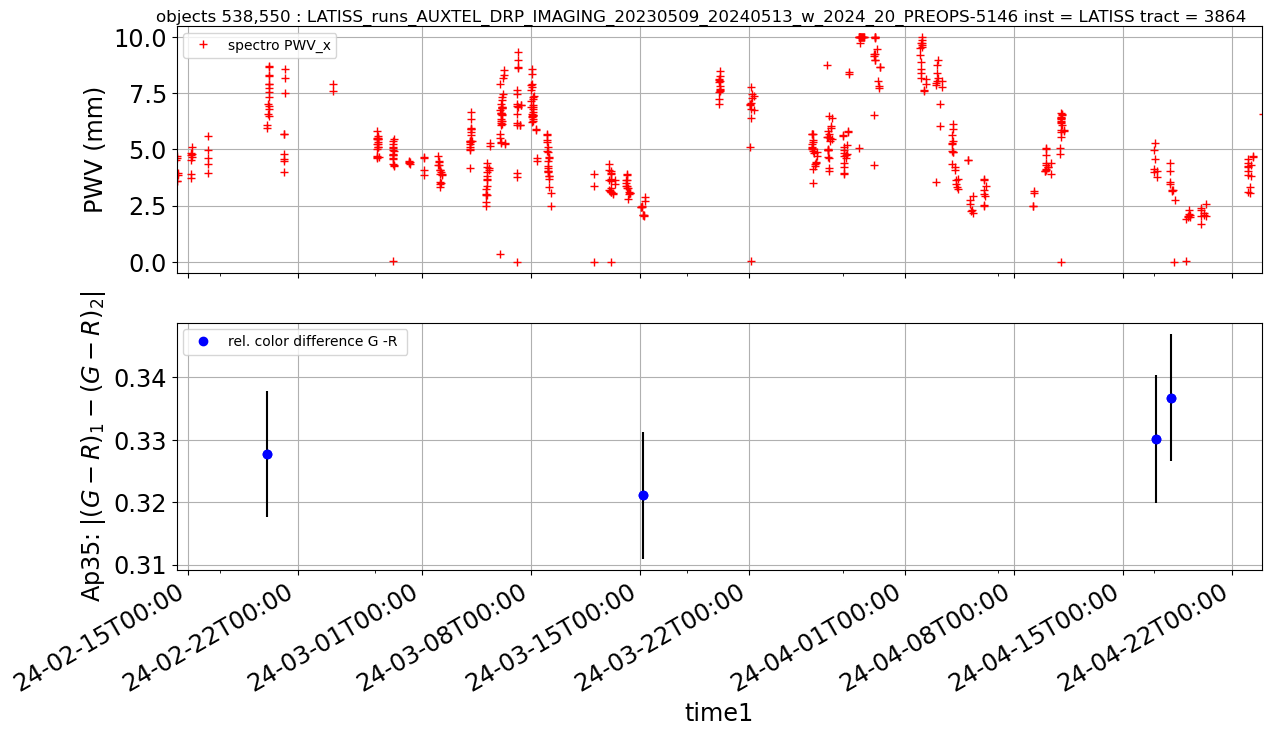

In [113]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_gr.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference G -R ")
ax2.errorbar(df_col_gr.time1,df_col_gr.apcol12_s12,yerr=df_col_gr.apcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_gr["time1"].min()
tmax = df_col_gr["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35: $|(G-R)_1-(G-R)_2|$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)

### G - Y bands

In [114]:
dfg_y = dfg_rzy[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfg_y.head()

time nightObs_y  \
nightObs visit                                                    
20231127 2023112700293 2023-11-28 06:39:00.978991104   20231127   
20231215 2023121500488 2023-12-16 05:48:58.151994880   20231215   
20240219 2024021900262 2024-02-20 00:56:12.722007040        NaN   
         2024021900265 2024-02-20 00:59:12.458996992        NaN   
         2024021900268 2024-02-20 01:02:12.365500928        NaN   

                              visit_y                         time_y  \
nightObs visit                                                         
20231127 2023112700293  2023112700292  2023-11-28T06:37:33.978497024   
20231215 2023121500488  2023121500487  2023-12-16T05:47:25.231009024   
20240219 2024021900262            NaN                            NaN   
         2024021900265            NaN                            NaN   
         2024021900268            NaN                            NaN   

                          dtsec_y  
nightObs visit                     
20231127 2023112700293 -87.000495  
20231215 2023121500488 -92.920986  
20240219 2024021900262        NaN  
         2024021900265        NaN  
         2024021900268        NaN

#### select close measurement in time

In [115]:
dfg_y_sel = dfg_y[np.abs(dfg_y["dtsec_y"]<3600)]

In [116]:
dfg_y_sel.head()

,,time,nightObs_y,visit_y,time_y,dtsec_y
nightObs,visit,,,,,
20231127,2023112700293,2023-11-28 06:39:00.978991104,20231127,2023112700292,2023-11-28T06:37:33.978497024,-87.000495
20231215,2023121500488,2023-12-16 05:48:58.151994880,20231215,2023121500487,2023-12-16T05:47:25.231009024,-92.920986
20240220,2024022000263,2024-02-21 01:19:25.365496064,20240220,2024022000262,2024-02-21T01:17:45.855508992,-99.509988
20240307,2024030700302,2024-03-08 05:39:54.095493888,20240307,2024030700301,2024-03-08T05:38:15.614507008,-98.480987
20240308,2024030800555,2024-03-09 05:45:36.472995072,20240308,2024030800554,2024-03-09T05:43:53.726494976,-102.746501


In [117]:
#df_col_gy = GetFluxes2StarsTwoBands("g","y",dfg_y_sel,df_g,df_y)
df_col_gy = GetFluxes2StarsTwoBandsNoCutout("g","y",dfg_y_sel,df_g,df_y)

0 (20231127, 2023112700293)
======================= night :: 20231127 ==> (g,y) = (2023112700293,2023112700292) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
1 (20231215, 2023121500488)
======================= night :: 20231215 ==> (g,y) = (2023121500488,2023121500487) =============================
2 (20240220, 2024022000263)
======================= night :: 20240220 ==> (g,y) = (2024022000263,2024022000262) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
3 (20240307, 2024030700302)
======================= night :: 20240307 ==> (g,y) = (2024030700302,2024030700301) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
4 (20240308, 2024030800555)
======================= night :: 20240308 ==> (g,y) = (2024030800555

In [118]:
df_col_gy.head()

,band1,exposure1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,band2,exposure2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt,deltapsfmag_s12b1,deltapsfmagErr_s12b1,deltaapmag_s12b1,deltaapmagErr_s12b1,deltapsfmag_s12b2,deltapsfmagErr_s12b2,deltaapmag_s12b2,deltaapmagErr_s12b2,psfcol12_s1,psfcol12Err_s1,apcol12_s1,apcol12Err_s1,psfcol12_s2,psfcol12Err_s2,apcol12_s2,apcol12Err_s2,psfcol12_s12,psfcol12Err_s12,apcol12_s12,apcol12Err_s12
0,g,2023121500488,2023-12-16 05:48:58.151994880,12.815720,14.938886,0.002389,0.003965,-15.223619,-13.089900,0.001099,0.007840,y,2023121500487,2023-12-16 05:47:25.231009024,12.815598,14.314140,0.004950,0.008155,-13.291246,-11.805865,0.004000,0.015711,-92.920986,-2.123166,0.004629,-2.133720,0.007916,-1.498541,0.009540,-1.485382,0.016212,0.000122,0.005497,-1.932373,0.004148,0.624746,0.009068,-1.284035,0.017558,0.624624,0.010604,0.648338,0.018042
1,g,2024031300217,2024-03-14 05:32:38.862006016,12.824088,14.940336,0.003020,0.004491,-15.144924,-13.021396,0.001147,0.008107,y,2024031300216,2024-03-14 05:31:00.952990976,12.843865,14.332224,0.005207,0.008963,-13.157943,-11.647754,0.004469,0.017959,-97.909016,-2.116248,0.005411,-2.123528,0.008188,-1.488359,0.010366,-1.510189,0.018506,-0.019777,0.006019,-1.986981,0.004614,0.608113,0.010025,-1.373641,0.019704,0.627889,0.011693,0.613340,0.020237
2,g,2024040500129,2024-04-06 02:34:47.426494976,12.803710,14.916501,0.002164,0.003821,-15.244221,-13.122040,0.001098,0.007756,y,2024040500132,2024-04-06 02:37:09.564005888,12.818552,14.303702,0.005630,0.008566,-13.318625,-11.892378,0.004109,0.015283,142.137510,-2.112791,0.004391,-2.122180,0.007833,-1.485150,0.010250,-1.426247,0.015825,-0.014842,0.006031,-1.925595,0.004253,0.612799,0.009379,-1.229662,0.017138,0.627641,0.011151,0.695933,0.017658
3,g,2024041900352,2024-04-20 02:02:17.550505984,12.795819,14.900119,0.002219,0.003938,-15.225819,-13.094650,0.001120,0.007974,y,2024041900355,2024-04-20 02:04:39.082503936,12.853465,14.364813,0.005189,0.008847,-13.257690,-11.744576,0.004148,0.016715,141.531997,-2.104300,0.004520,-2.131169,0.008052,-1.511348,0.010256,-1.513114,0.017222,-0.057646,0.005643,-1.968128,0.004297,0.535305,0.009684,-1.350074,0.018519,0.592951,0.011208,0.618054,0.019011


Text(0.5, 0.9, 'objects 538,550 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146 inst = LATISS tract = 3864')

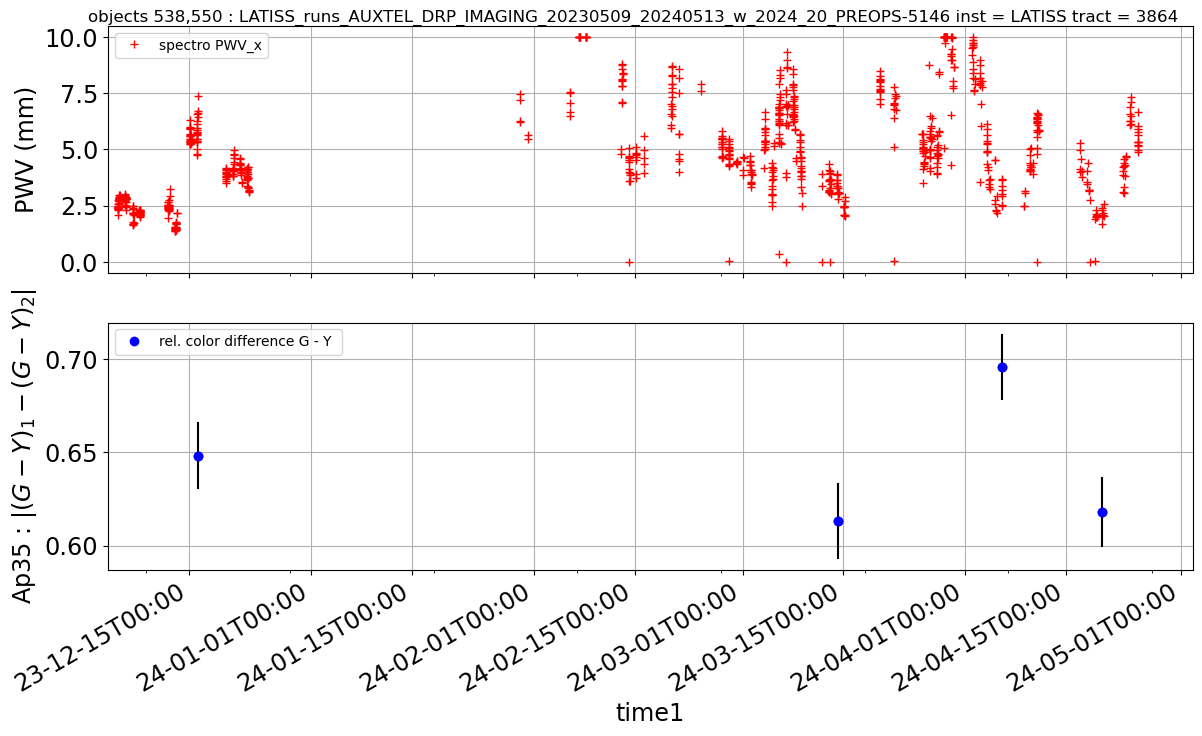

In [119]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_gy.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference G - Y ")
ax2.errorbar(df_col_gy.time1,df_col_gy.apcol12_s12,yerr=df_col_gy.apcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_gy["time1"].min()
tmax = df_col_gy["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35 : $|(G-Y)_1-(G-Y)_2|$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)

### R - Y bands

In [120]:
dfr_y = dfr_zy[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfr_y.head()

time nightObs_y  \
nightObs visit                                                    
20231115 2023111500561 2023-11-16 08:32:50.921996032        NaN   
20231120 2023112000374 2023-11-21 08:24:48.475009024        NaN   
20231121 2023112100595 2023-11-22 08:27:24.762504960   20231121   
20231127 2023112700294 2023-11-28 06:39:47.577990912   20231127   
         2023112700394 2023-11-28 08:11:20.978504960   20231127   

                              visit_y                         time_y  \
nightObs visit                                                         
20231115 2023111500561            NaN                            NaN   
20231120 2023112000374            NaN                            NaN   
20231121 2023112100595  2023112100597  2023-11-22T08:28:59.319991040   
20231127 2023112700294  2023112700296  2023-11-28T06:41:22.040489984   
         2023112700394  2023112700400  2023-11-28T08:16:42.899004928   

                           dtsec_y  
nightObs visit                      
20231115 2023111500561         NaN  
20231120 2023112000374         NaN  
20231121 2023112100595   94.557486  
20231127 2023112700294   94.462499  
         2023112700394  321.920499

In [121]:
dfr_y_sel = dfr_y[np.abs(dfr_y["dtsec_y"])<3600]

In [122]:
#df_col_ry = GetFluxes2StarsTwoBands("r","y",dfr_y_sel,df_r,df_y)
df_col_ry = GetFluxes2StarsTwoBandsNoCutout("r","y",dfr_y_sel,df_r,df_y)

0 (20231121, 2023112100595)
======================= night :: 20231121 ==> (r,y) = (2023112100595,2023112100597) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
1 (20231127, 2023112700294)
======================= night :: 20231127 ==> (r,y) = (2023112700294,2023112700296) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
2 (20231127, 2023112700394)
======================= night :: 20231127 ==> (r,y) = (2023112700394,2023112700400) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
3 (20231205, 2023120500470)
======================= night :: 20231205 ==> (r,y) = (2023120500470,2023120500464) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer i

In [123]:
df_col_ry.head() 

,band1,exposure1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,band2,exposure2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt,deltapsfmag_s12b1,deltapsfmagErr_s12b1,deltaapmag_s12b1,deltaapmagErr_s12b1,deltapsfmag_s12b2,deltapsfmagErr_s12b2,deltaapmag_s12b2,deltaapmagErr_s12b2,psfcol12_s1,psfcol12Err_s1,apcol12_s1,apcol12Err_s1,psfcol12_s2,psfcol12Err_s2,apcol12_s2,apcol12Err_s2,psfcol12_s12,psfcol12Err_s12,apcol12_s12,apcol12Err_s12
0,r,2023120600245,2023-12-07 06:29:11.490004992,12.799058,14.587926,0.001865,0.003294,-15.086598,-13.294751,0.001173,0.006109,y,2023120600247,2023-12-07 06:30:46.831505920,12.915042,14.420988,0.004077,0.007152,-13.387200,-11.850792,0.003645,0.015005,95.341500,-1.788868,0.003786,-1.791846,0.006221,-1.505946,0.008232,-1.536408,0.015441,-0.115984,0.004483,-1.699398,0.003829,0.166938,0.007874,-1.443959,0.016201,0.282922,0.009061,0.255439,0.016647
1,r,2023121100516,2023-12-12 05:51:08.016002048,12.799103,14.572842,0.002399,0.003705,-15.070331,-13.281394,0.001213,0.006304,y,2023121100518,2023-12-12 05:52:42.592496896,12.820520,14.314291,0.005181,0.008093,-13.367495,-11.893692,0.003923,0.015245,94.576494,-1.773740,0.004414,-1.788937,0.006420,-1.493771,0.009610,-1.473803,0.015742,-0.021417,0.005709,-1.702836,0.004106,0.258551,0.008901,-1.387702,0.016497,0.279968,0.010575,0.315134,0.017001
2,r,2023122200474,2023-12-23 05:34:31.479500032,12.816451,14.598974,0.002164,0.003496,-15.077155,-13.305595,0.001206,0.006165,y,2023122200476,2023-12-23 05:36:06.928993024,12.917984,14.374545,0.004334,0.007295,-13.350645,-11.921415,0.003820,0.014249,95.449492,-1.782523,0.004111,-1.771561,0.006281,-1.456562,0.008485,-1.429231,0.014752,-0.101533,0.004844,-1.726510,0.004006,0.224428,0.008089,-1.384180,0.015525,0.325961,0.009429,0.342330,0.016034
3,r,2024022000268,2024-02-21 01:24:08.909498112,12.917733,14.683866,0.002178,0.003504,-15.063529,-13.278344,0.001231,0.006370,y,2024022000270,2024-02-21 01:25:43.897996032,12.830497,14.339395,0.004247,0.007486,-13.318537,-11.810672,0.004061,0.016283,94.988497,-1.766133,0.004126,-1.785185,0.006488,-1.508898,0.008607,-1.507864,0.016782,0.087236,0.004773,-1.744992,0.004243,0.344471,0.008266,-1.467671,0.017485,0.257236,0.009545,0.277321,0.017992
4,r,2024022000272,2024-02-21 01:28:03.793499904,12.793284,14.583690,0.002526,0.003732,-15.064197,-13.274035,0.001207,0.006280,y,2024022000274,2024-02-21 01:29:38.788992000,12.598293,14.132473,0.004381,0.007543,-13.307120,-11.819553,0.003926,0.015451,94.995492,-1.790406,0.004507,-1.790162,0.006395,-1.534180,0.008723,-1.487568,0.015942,0.194991,0.005058,-1.757076,0.004107,0.451217,0.008416,-1.454483,0.016678,0.256226,0.009819,0.302594,0.017176


In [124]:
df_col_ry = df_col_ry[np.abs(df_col_ry["dt"])<3600]

Text(0.5, 0.9, 'objects 538,550 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146 inst = LATISS tract = 3864')

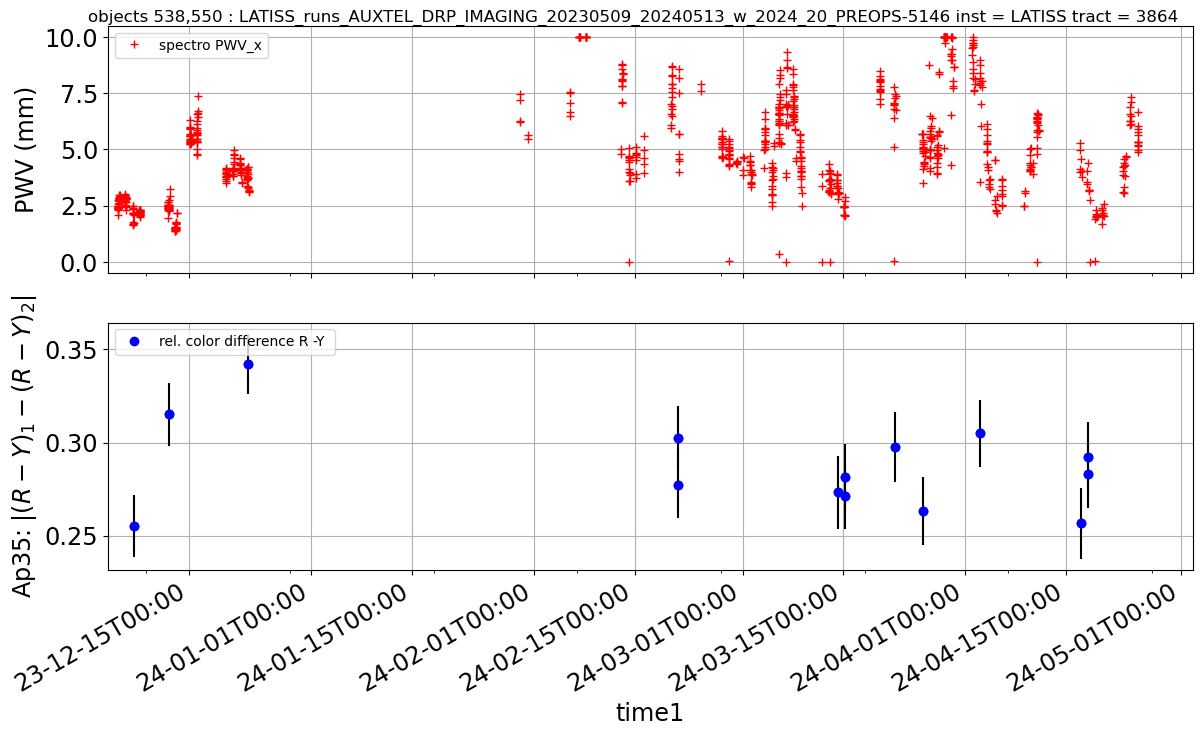

In [125]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_ry.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference R -Y ")
ax2.errorbar(df_col_ry.time1,df_col_ry.apcol12_s12,yerr=df_col_ry.apcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_gy["time1"].min()
tmax = df_col_gy["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)

ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35: $|(R-Y)_1-(R-Y)_2|$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)

### Z - Y bands

In [126]:
#dfz_y = dfz_y[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfz_y.head()

time nightObs_y  \
nightObs visit                                                    
20231121 2023112100544 2023-11-22 07:38:35.521490944   20231121   
         2023112100596 2023-11-22 08:28:11.230505984   20231121   
20231127 2023112700295 2023-11-28 06:40:34.326006016   20231127   
         2023112700395 2023-11-28 08:12:07.693991936   20231127   
20231204 2023120400517 2023-12-05 06:13:23.257491968   20231204   

                              visit_y                         time_y  \
nightObs visit                                                         
20231121 2023112100544  2023112100549  2023-11-22T07:43:14.763491072   
         2023112100596  2023112100597  2023-11-22T08:28:59.319991040   
20231127 2023112700295  2023112700296  2023-11-28T06:41:22.040489984   
         2023112700395  2023112700400  2023-11-28T08:16:42.899004928   
20231204 2023120400517  2023120400518  2023-12-05T06:14:11.225009920   

                           dtsec_y  
nightObs visit                      
20231121 2023112100544     279.242  
         2023112100596   48.089485  
20231127 2023112700295   47.714483  
         2023112700395  275.205012  
20231204 2023120400517   47.967517

In [127]:
dfz_y_sel = dfz_y[np.abs(dfz_y["dtsec_y"])<3600]

In [128]:
#dfz_y_sel

In [129]:
#df_col_zy = GetFluxes2StarsTwoBands("z","y",dfz_y_sel,df_z,df_y)
df_col_zy = GetFluxes2StarsTwoBandsNoCutout("z","y",dfz_y_sel,df_z,df_y)

0 (20231121, 2023112100544)
======================= night :: 20231121 ==> (z,y) = (2023112100544,2023112100549) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
1 (20231121, 2023112100596)
======================= night :: 20231121 ==> (z,y) = (2023112100596,2023112100597) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
2 (20231127, 2023112700295)
======================= night :: 20231127 ==> (z,y) = (2023112700295,2023112700296) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
3 (20231127, 2023112700395)
======================= night :: 20231127 ==> (z,y) = (2023112700395,2023112700400) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer i

In [130]:
df_col_zy = df_col_zy[np.abs(df_col_zy["dt"])<3600]

Text(0.5, 0.9, 'objects 538,550 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146 inst = LATISS tract = 3864')

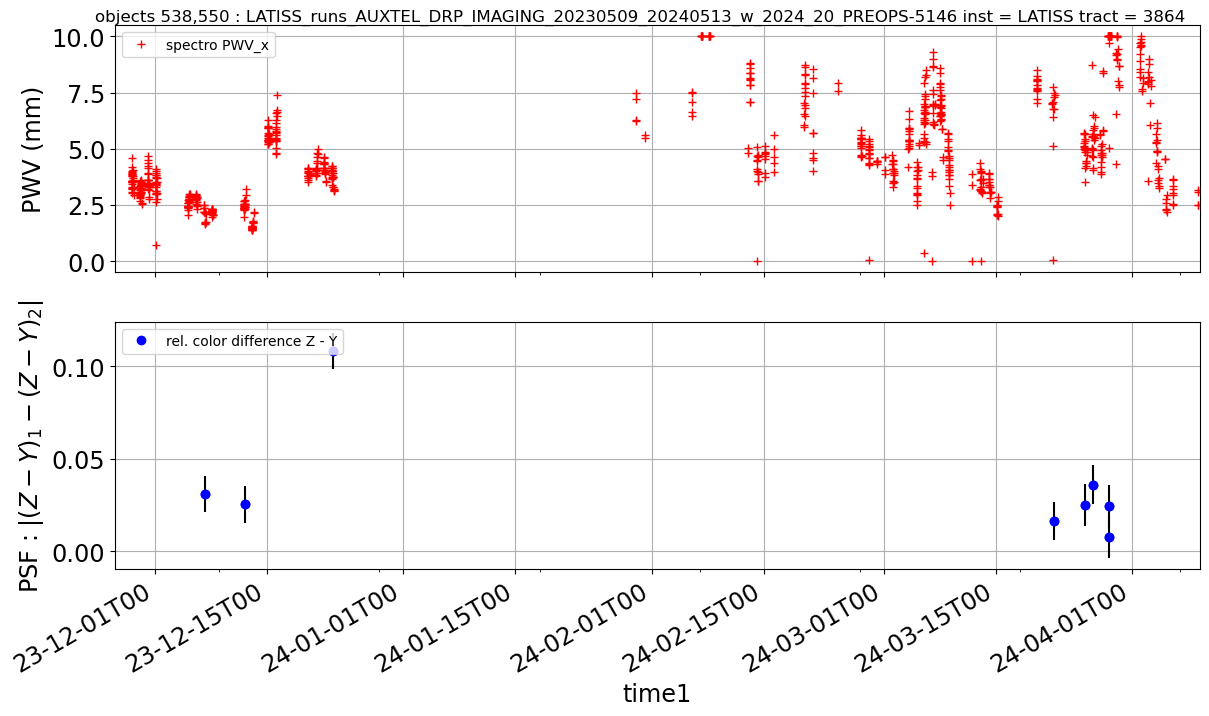

In [131]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%dT%H")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_zy.plot(x="time1",y="psfcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference Z - Y")
ax2.errorbar(df_col_zy.time1,df_col_zy.psfcol12_s12,yerr=df_col_zy.psfcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_zy["time1"].min()
tmax = df_col_zy["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("PSF : $|(Z-Y)_1-(Z-Y)_2|$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)

Text(0.5, 0.9, 'objects 538,550 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146 inst = LATISS tract = 3864')

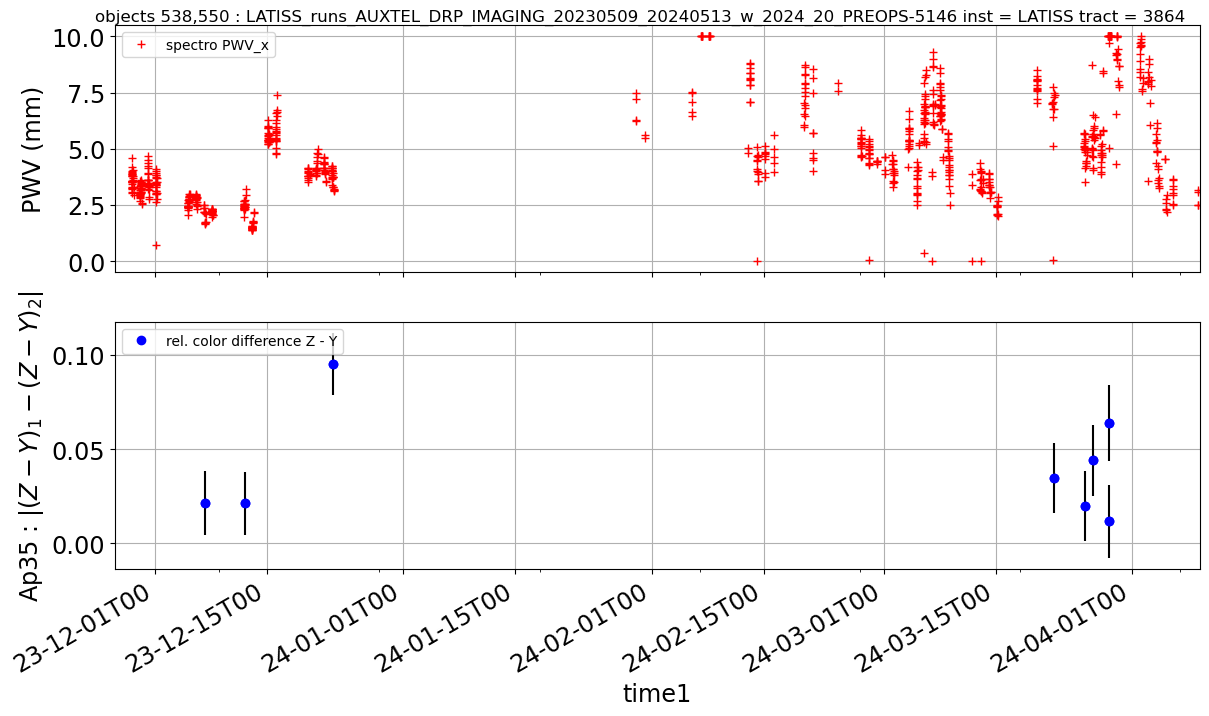

In [132]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%dT%H")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_zy.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference Z - Y")
ax2.errorbar(df_col_zy.time1,df_col_zy.apcol12_s12,yerr=df_col_zy.apcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_zy["time1"].min()
tmax = df_col_zy["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35 : $|(Z-Y)_1-(Z-Y)_2|$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)